In [2]:
import scanpy as sc
import pandas as pd
import unitvelo as utv
import leidenalg
import scvelo as scv
scv.settings.verbosity = 0
import tensorflow as tf
print ("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import cellrank as cr


(Running UniTVelo 0.1.6)
2022-05-12 08:31:18


2022-05-12 10:31:19.110996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Num GPUs Available:  0


2022-05-12 10:31:40.790756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-12 10:31:40.790798: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


# scVI embedding

This was run on the cluster using the old datset with only three timepoints.

In [3]:
rna = sc.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/scvi_10_dim_old_data/anndata_object")

In [4]:
#sc.tl.pca(rna)
#sc.pp.neighbors(rna, n_pcs=30, n_neighbors=20)
sc.pp.neighbors(rna, use_rep="X_scVI")

sc.tl.umap(rna, min_dist=0.1)

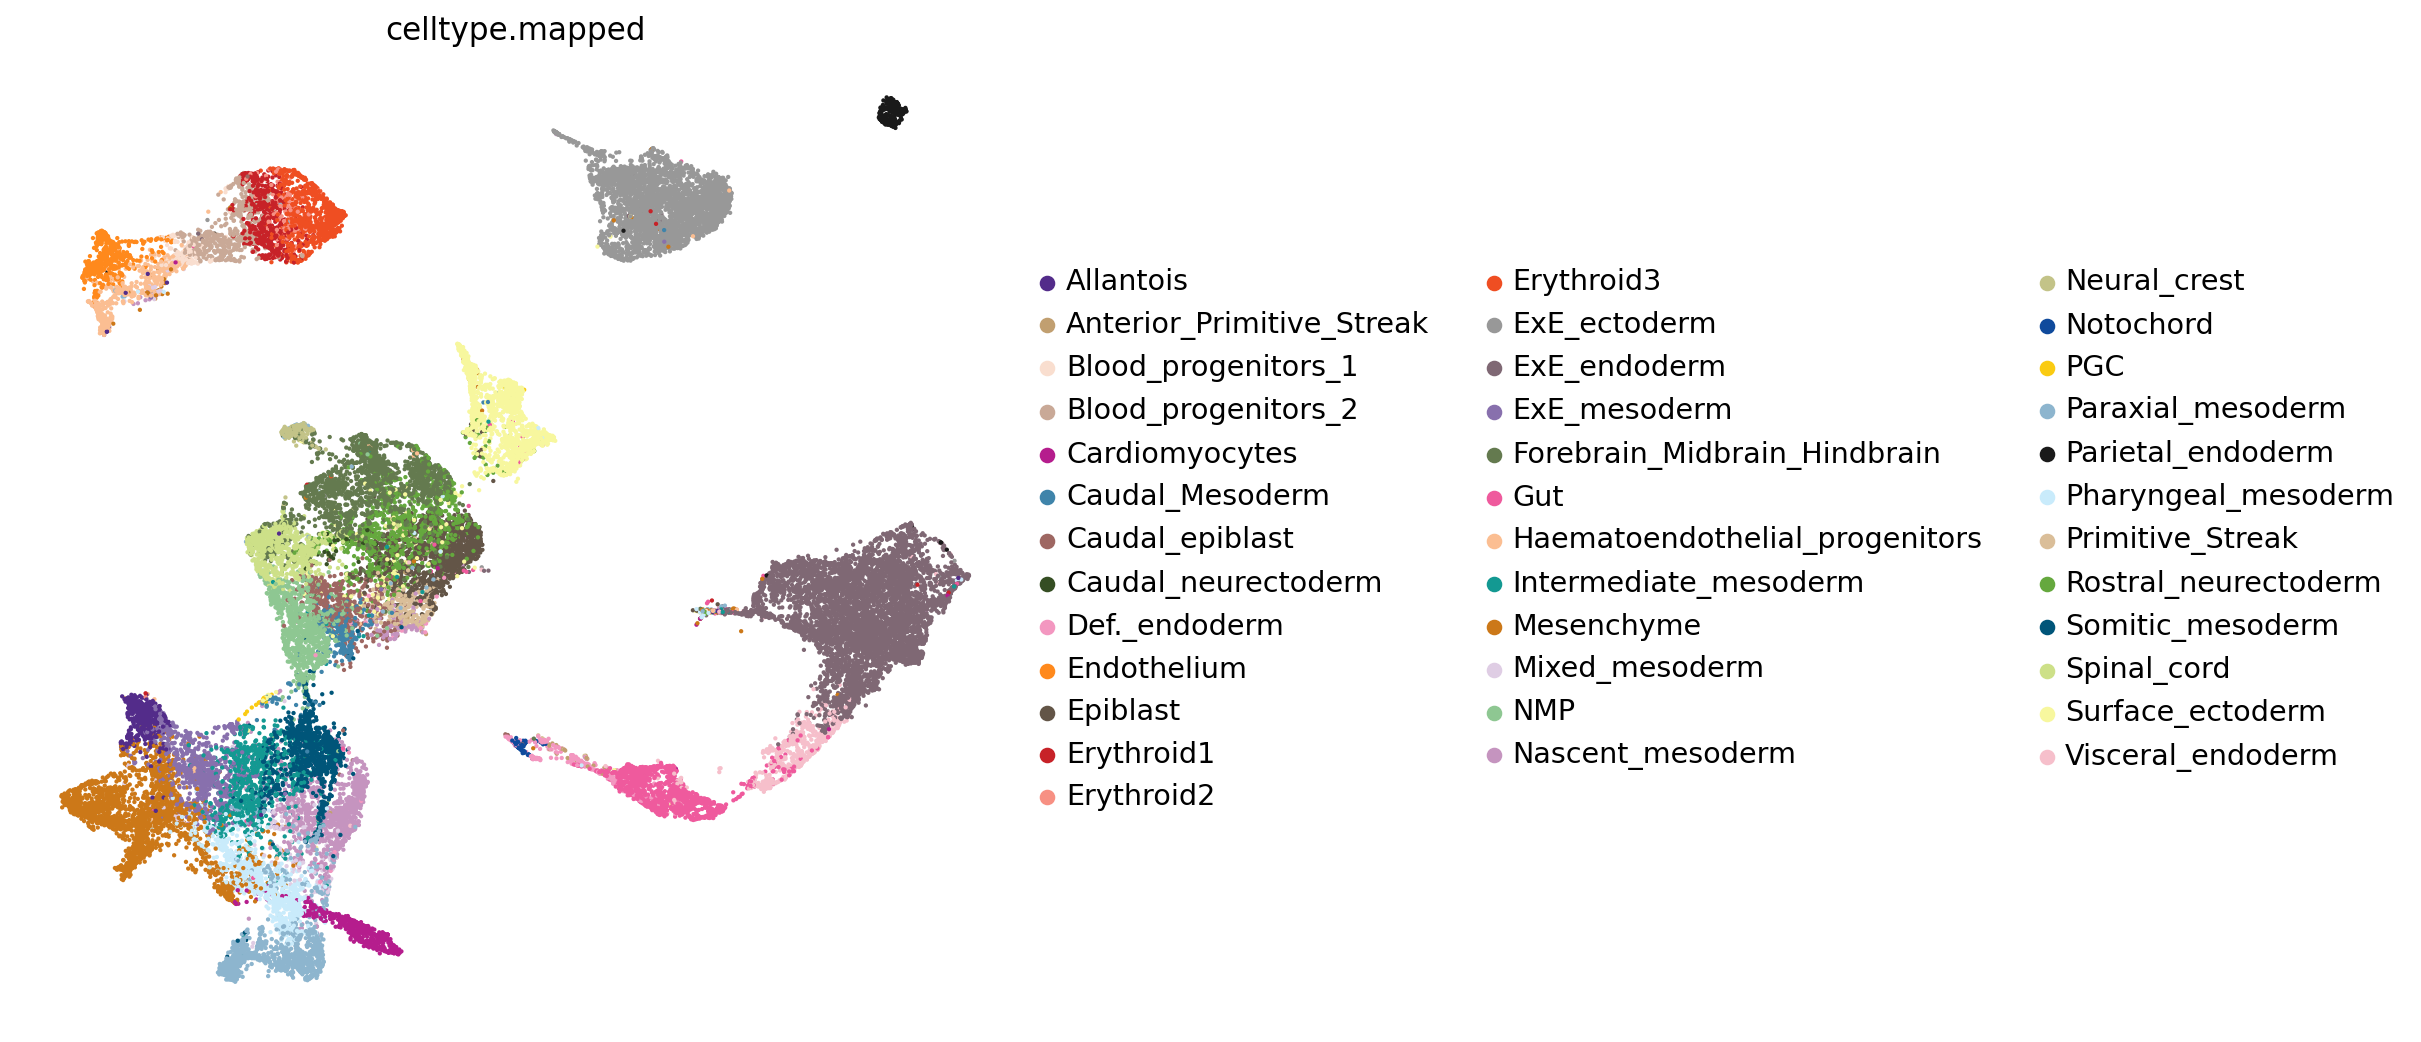

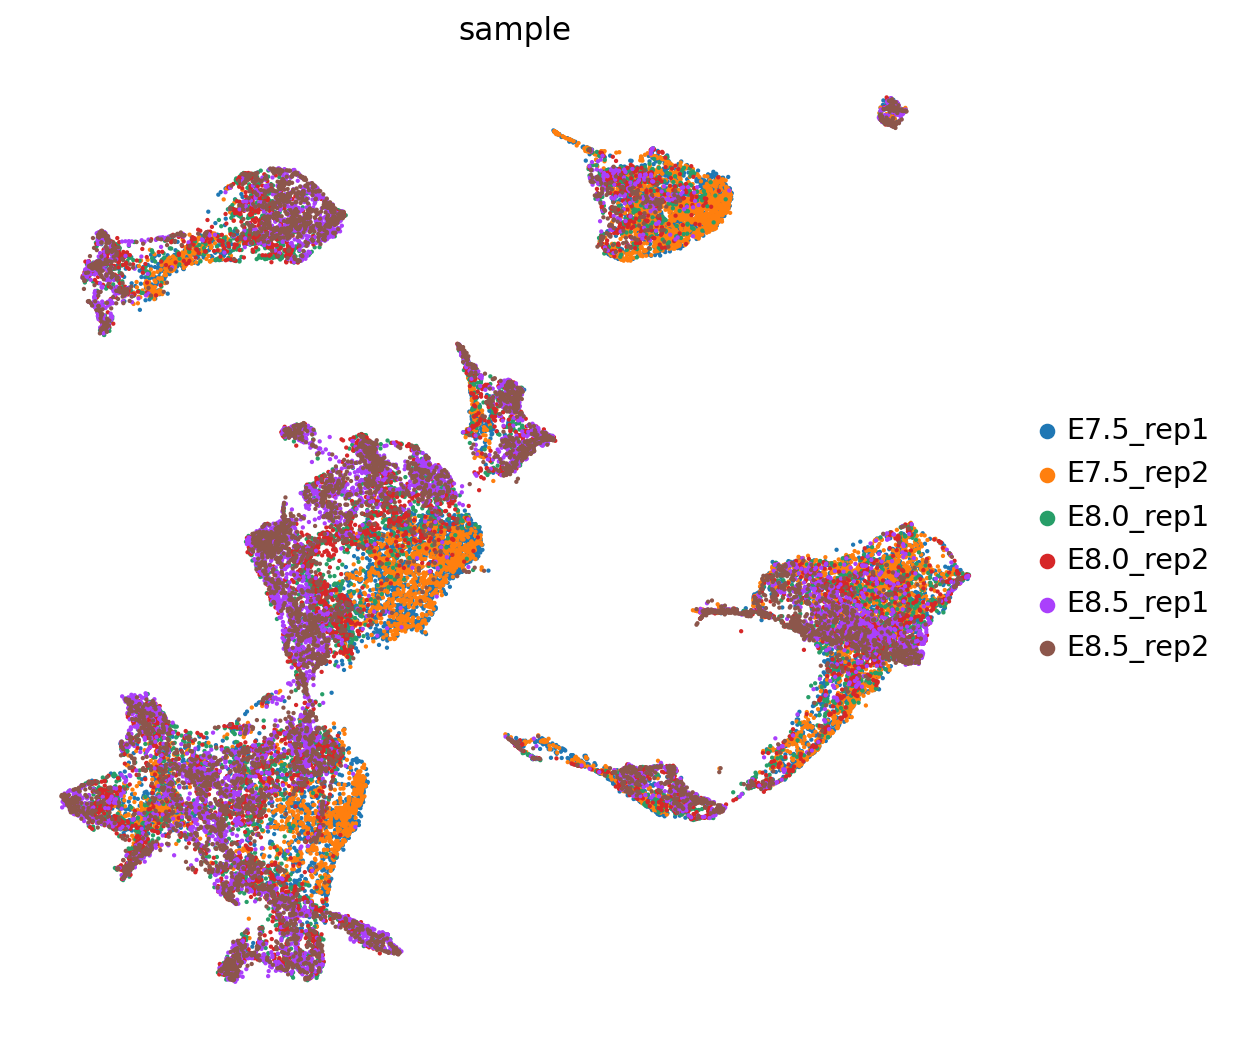

In [5]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(
    rna,
    color=["celltype.mapped"],
    frameon=False,
    size=15
)
sc.pl.umap(
    rna,
    color=["sample"],
    ncols=2,
    frameon=False,
    size=15
)

## PeakVI embedding

In [42]:
rna_peak = sc.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/peakvi_20_dim_old_data/anndata_object_peakvi")

In [43]:
rna_peak

AnnData object with n_obs × n_vars = 36822 × 11444
    obs: 'sample', 'barcode', 'stage', 'nFeature_RNA', 'nCount_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'pass_rnaQC', 'celltype.mapped', 'celltype.score', 'closest.cell', 'hybrid_score', 'doublet_call', 'TSSEnrichment_atac', 'ReadsInTSS_atac', 'PromoterRatio_atac', 'NucleosomeRatio_atac', 'nFrags_atac', 'BlacklistRatio_atac', 'pass_atacQC', 'celltype.predicted', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', '_scvi_batch', '_scvi_labels'
    var: 'gene', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype.mapped_colors', 'stage_colors'
    obsm: 'X_PeakVI', '_scvi_extra_categorical_covs'
    layers: 'csr', 'spliced', 'unspliced'

In [44]:
#sc.tl.pca(rna)
#sc.pp.neighbors(rna, n_pcs=30, n_neighbors=20)
sc.pp.neighbors(rna_peak, use_rep="X_PeakVI")

sc.tl.umap(rna_peak, min_dist=0.1)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


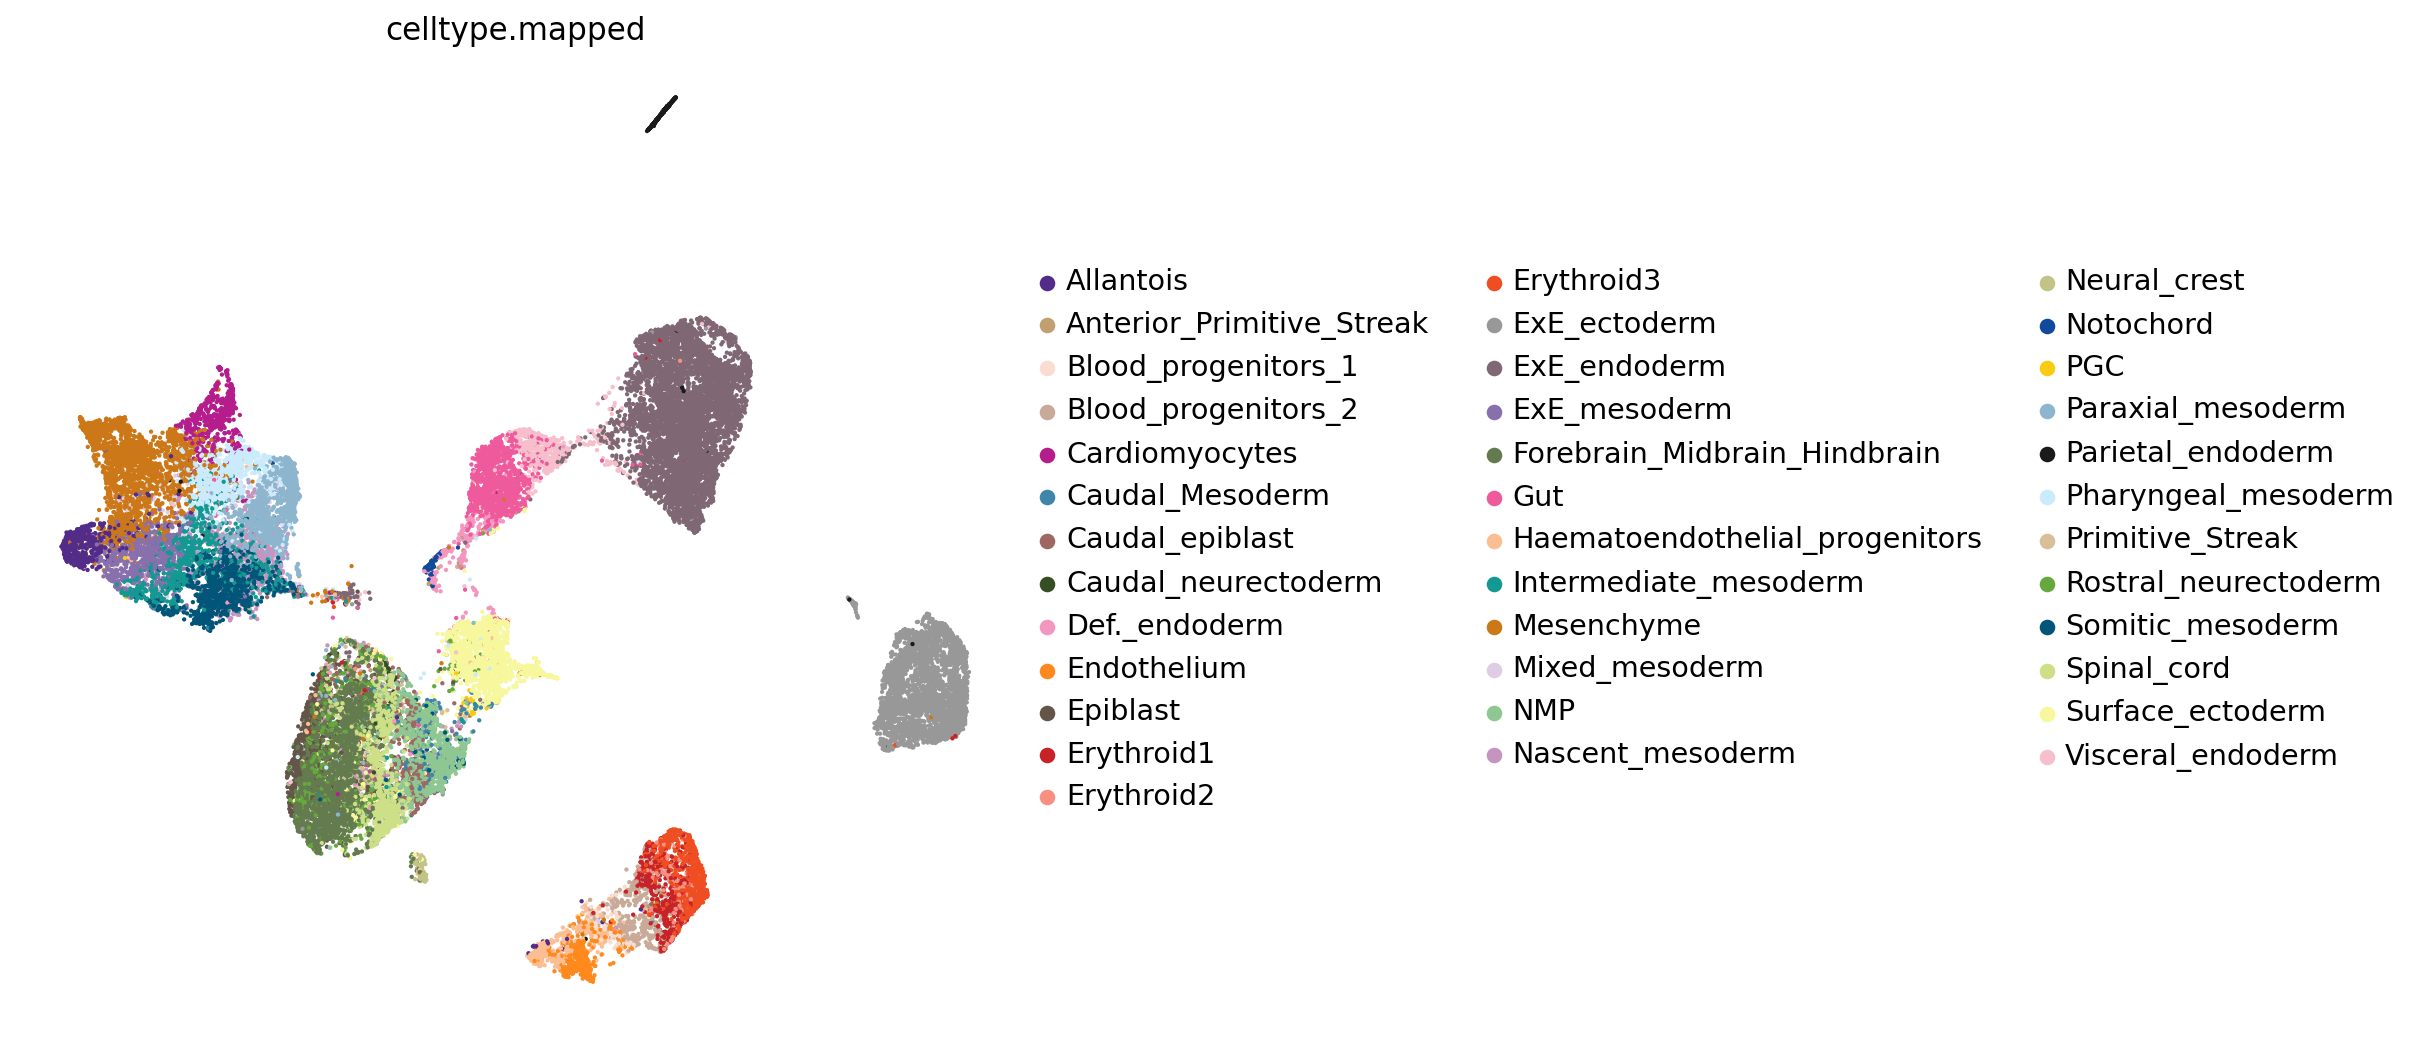

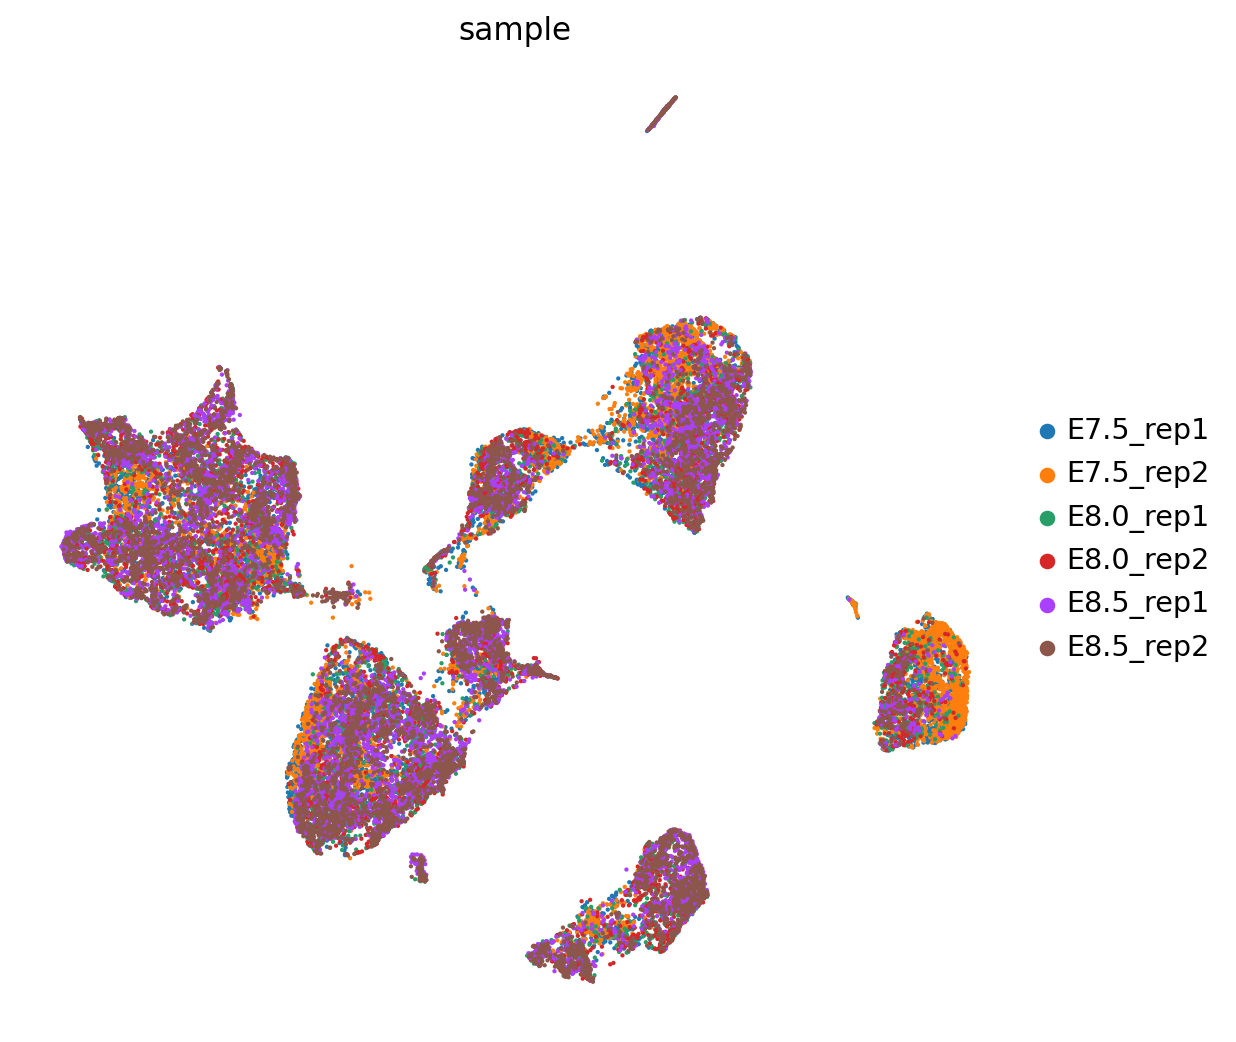

In [45]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(
    rna_peak,
    color=["celltype.mapped"],
    frameon=False,
    size=15
)
sc.pl.umap(
    rna_peak,
    color=["sample"],
    ncols=2,
    frameon=False,
    size=15
)

# UniTVelo
this was run on the cluster

## Mesoderm

In [14]:
mesoderm = rna[rna.obs["celltype.mapped"].isin(["Anterior_Primitive_Streak", "PGC", "Notochord", "Cardiomyocytes", "Mesenchyme", "Allantois", "Primitive_Streak", "Paraxial_mesoderm", "Pharyngeal_mesoderm", "Somitic_mesoderm", "Nascent_mesoderm", "NMP", "Mixed_mesoderm", "Intermediate_mesoderm", "Caudal_Mesoderm"])] 

In [15]:
mesoderm.X = mesoderm.layers["counts"].todense()

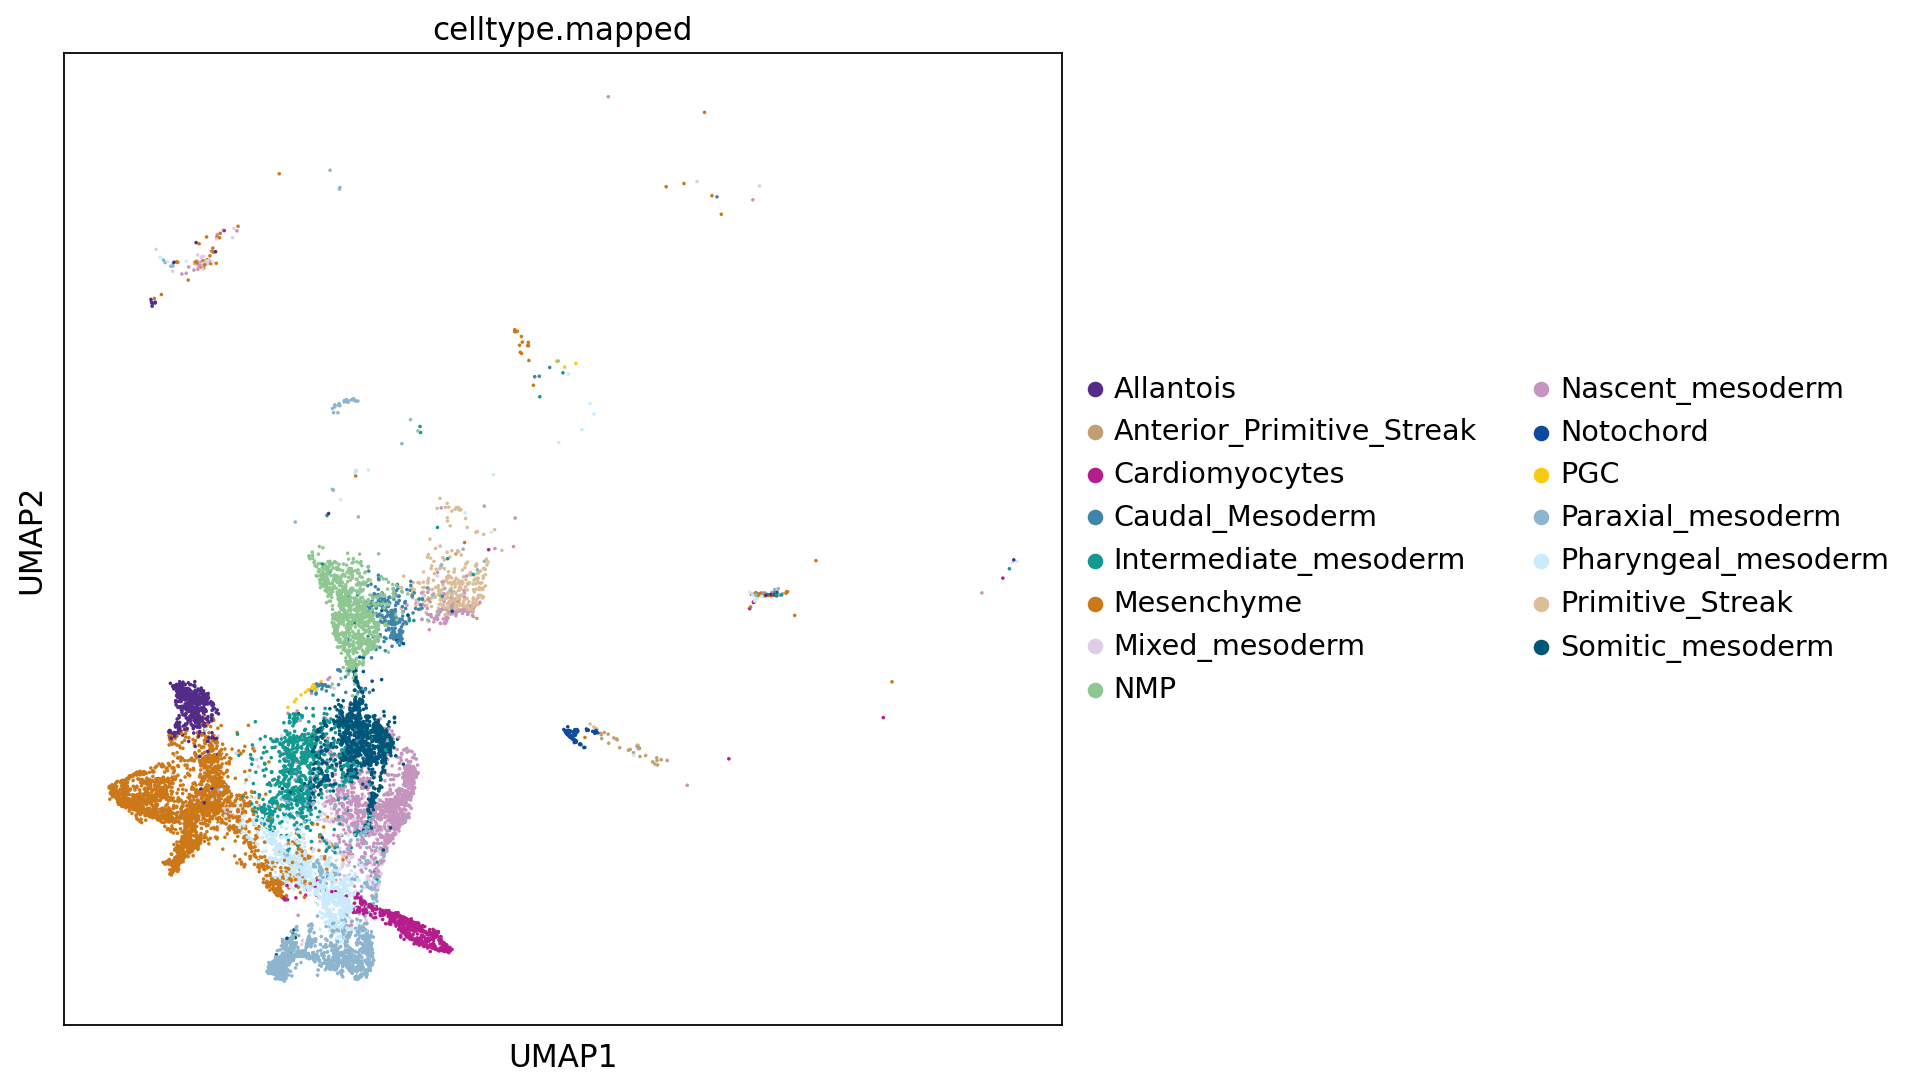

In [16]:
sc.pl.umap(mesoderm, color = "celltype.mapped")

In [17]:
#sc.write("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/UniTVelo/mesoderm.h5ad", mesoderm)

In [29]:
label = "celltype.mapped"

In [30]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = '1'
velo_config.GPU = -1

### Use bifurcating trajectory

In [32]:
adata = sc.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/UniTVelo/unitvelo_mesoderm.h5ad")

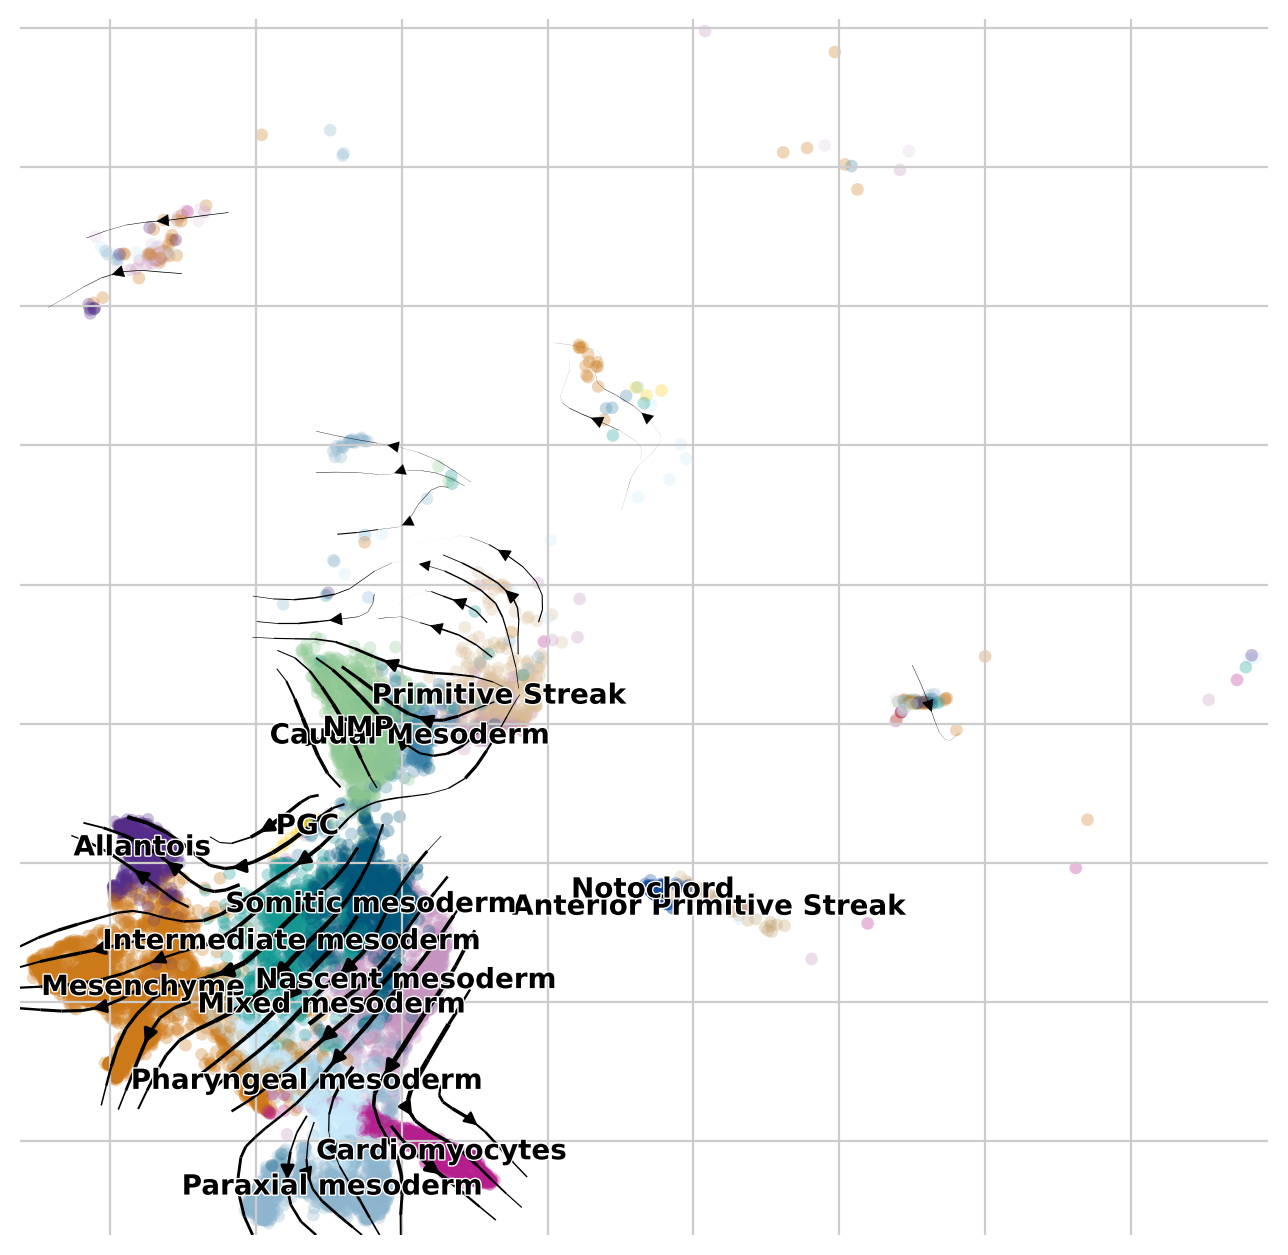

In [33]:
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='', legend_fontsize = 10)

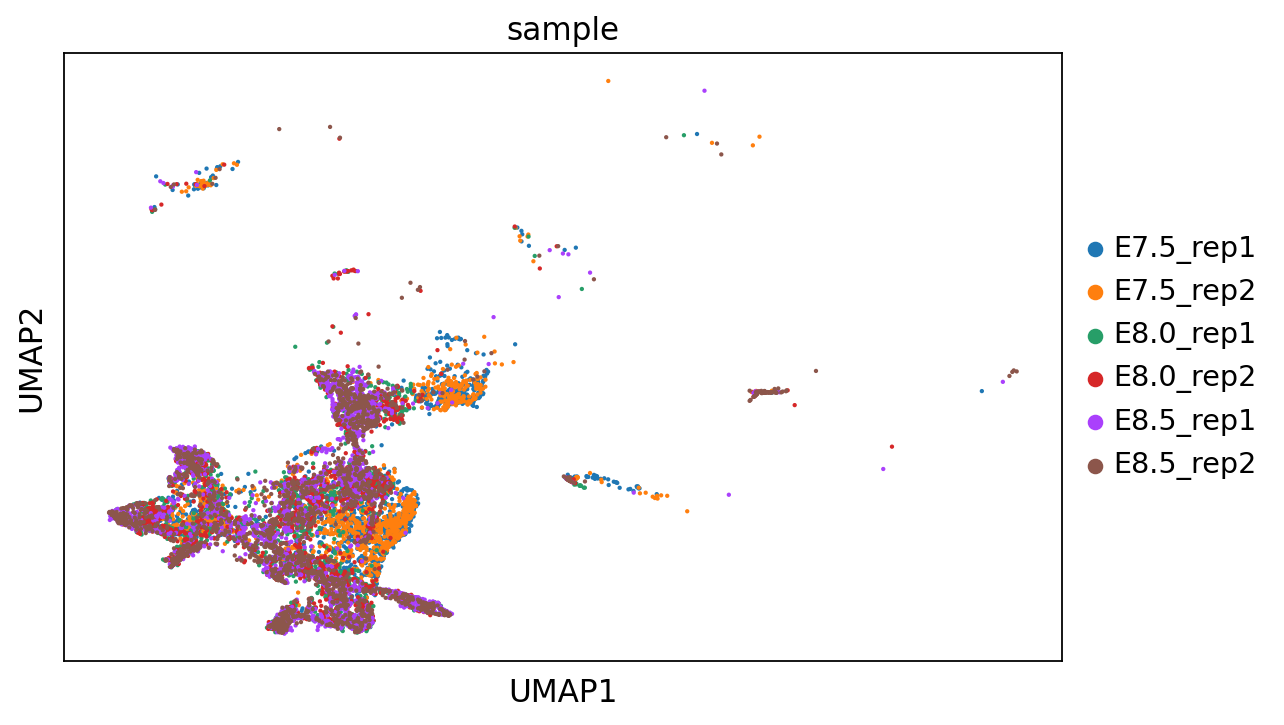

In [34]:
sc.set_figure_params(figsize=(8,5))
sc.pl.umap(adata, color = "sample", size = 15)

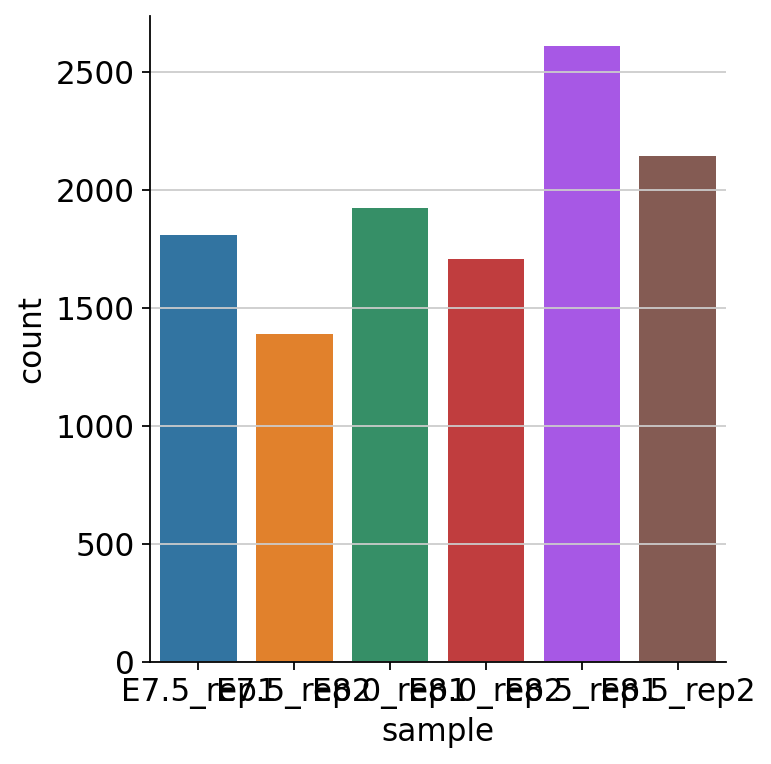

In [35]:
import seaborn as sns
sc.set_figure_params(figsize=(8,15))
sns.catplot(x="sample",  kind="count", data=adata.obs)

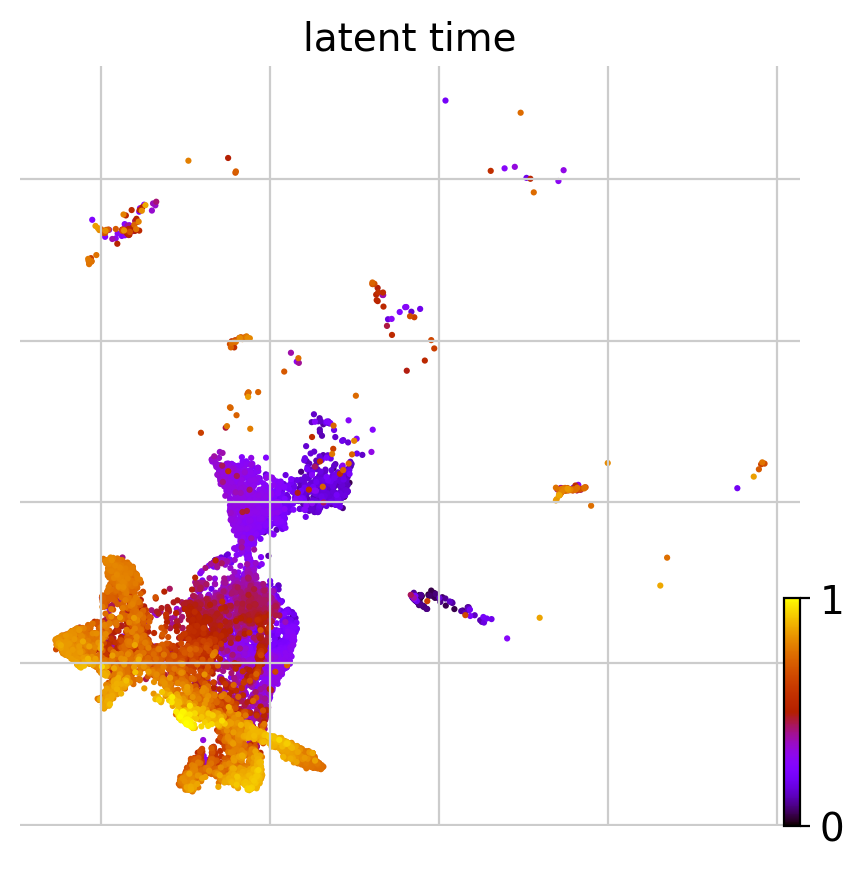

In [36]:
sc.set_figure_params(figsize=(5,5))

scv.tl.latent_time(adata, min_likelihood=None)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20, dpi=100)

In [37]:
subvar = adata.var.loc[adata.var['velocity_genes'] == True]
sub = adata[:, subvar.index]

Text(0.5, 1.0, 'Peak Time')

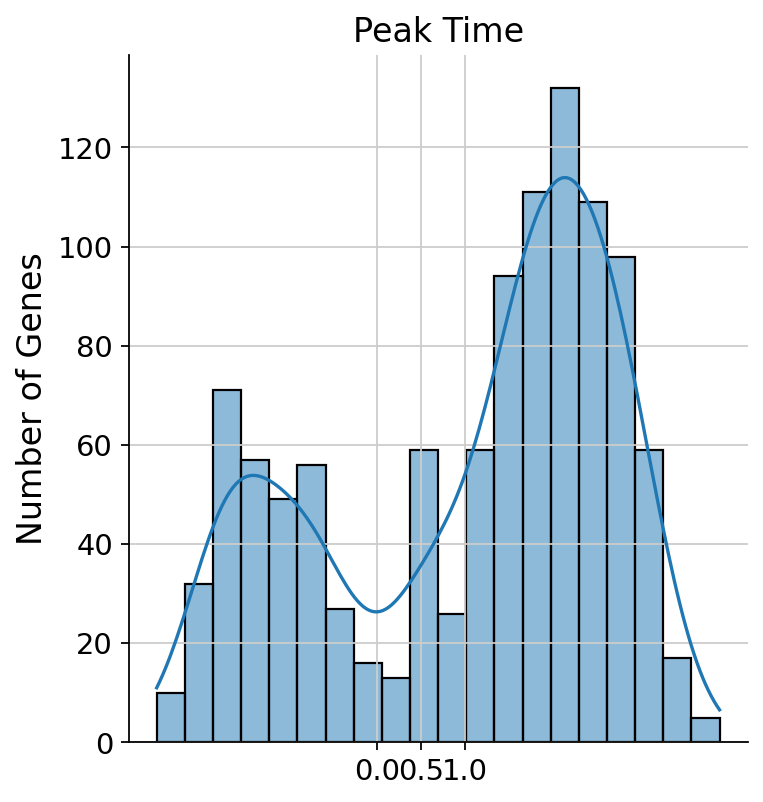

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(sub.var['fit_t0'].values, kde=True, bins=20)
plt.xticks([0, 0.5, 1], fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Number of Genes', fontsize=15)
plt.title('Peak Time', fontsize=15)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.
/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/cellrank/tl/_init_term_states.py:161: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  **kwargs,


  0%|          | 0/11577 [00:00<?, ?cell/s]

  0%|          | 0/11577 [00:00<?, ?cell/s]

Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999389e-01 -9.9134663439177683e-06 1.2046760995687094e-03 
0.0000000000000000e+00 9.9991476032721438e-01 -2.7588763812563593e-04 
0.0000000000000000e+00 0.0000000000000000e+00 9.9688391717037861e-01 


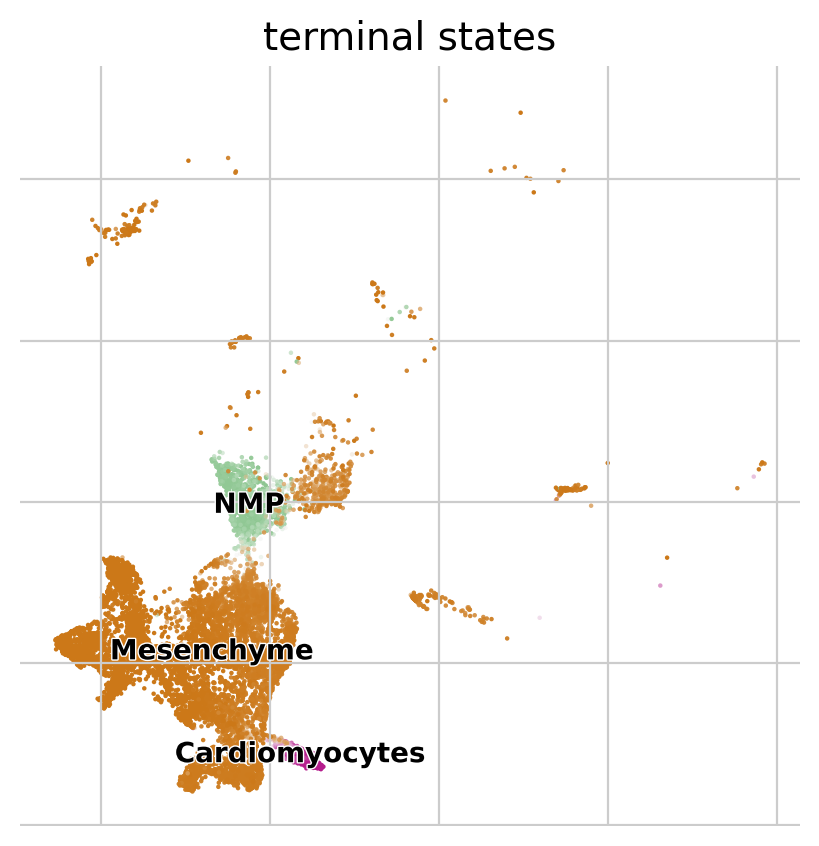

In [39]:
cr.tl.terminal_states(adata, cluster_key=label, weight_connectivities=0.2)#, n_states=4)
cr.pl.terminal_states(adata, dpi = 100, legend_fontsize=10)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.
/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/cellrank/tl/_init_term_states.py:161: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  **kwargs,


  0%|          | 0/11577 [00:00<?, ?cell/s]

  0%|          | 0/11577 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


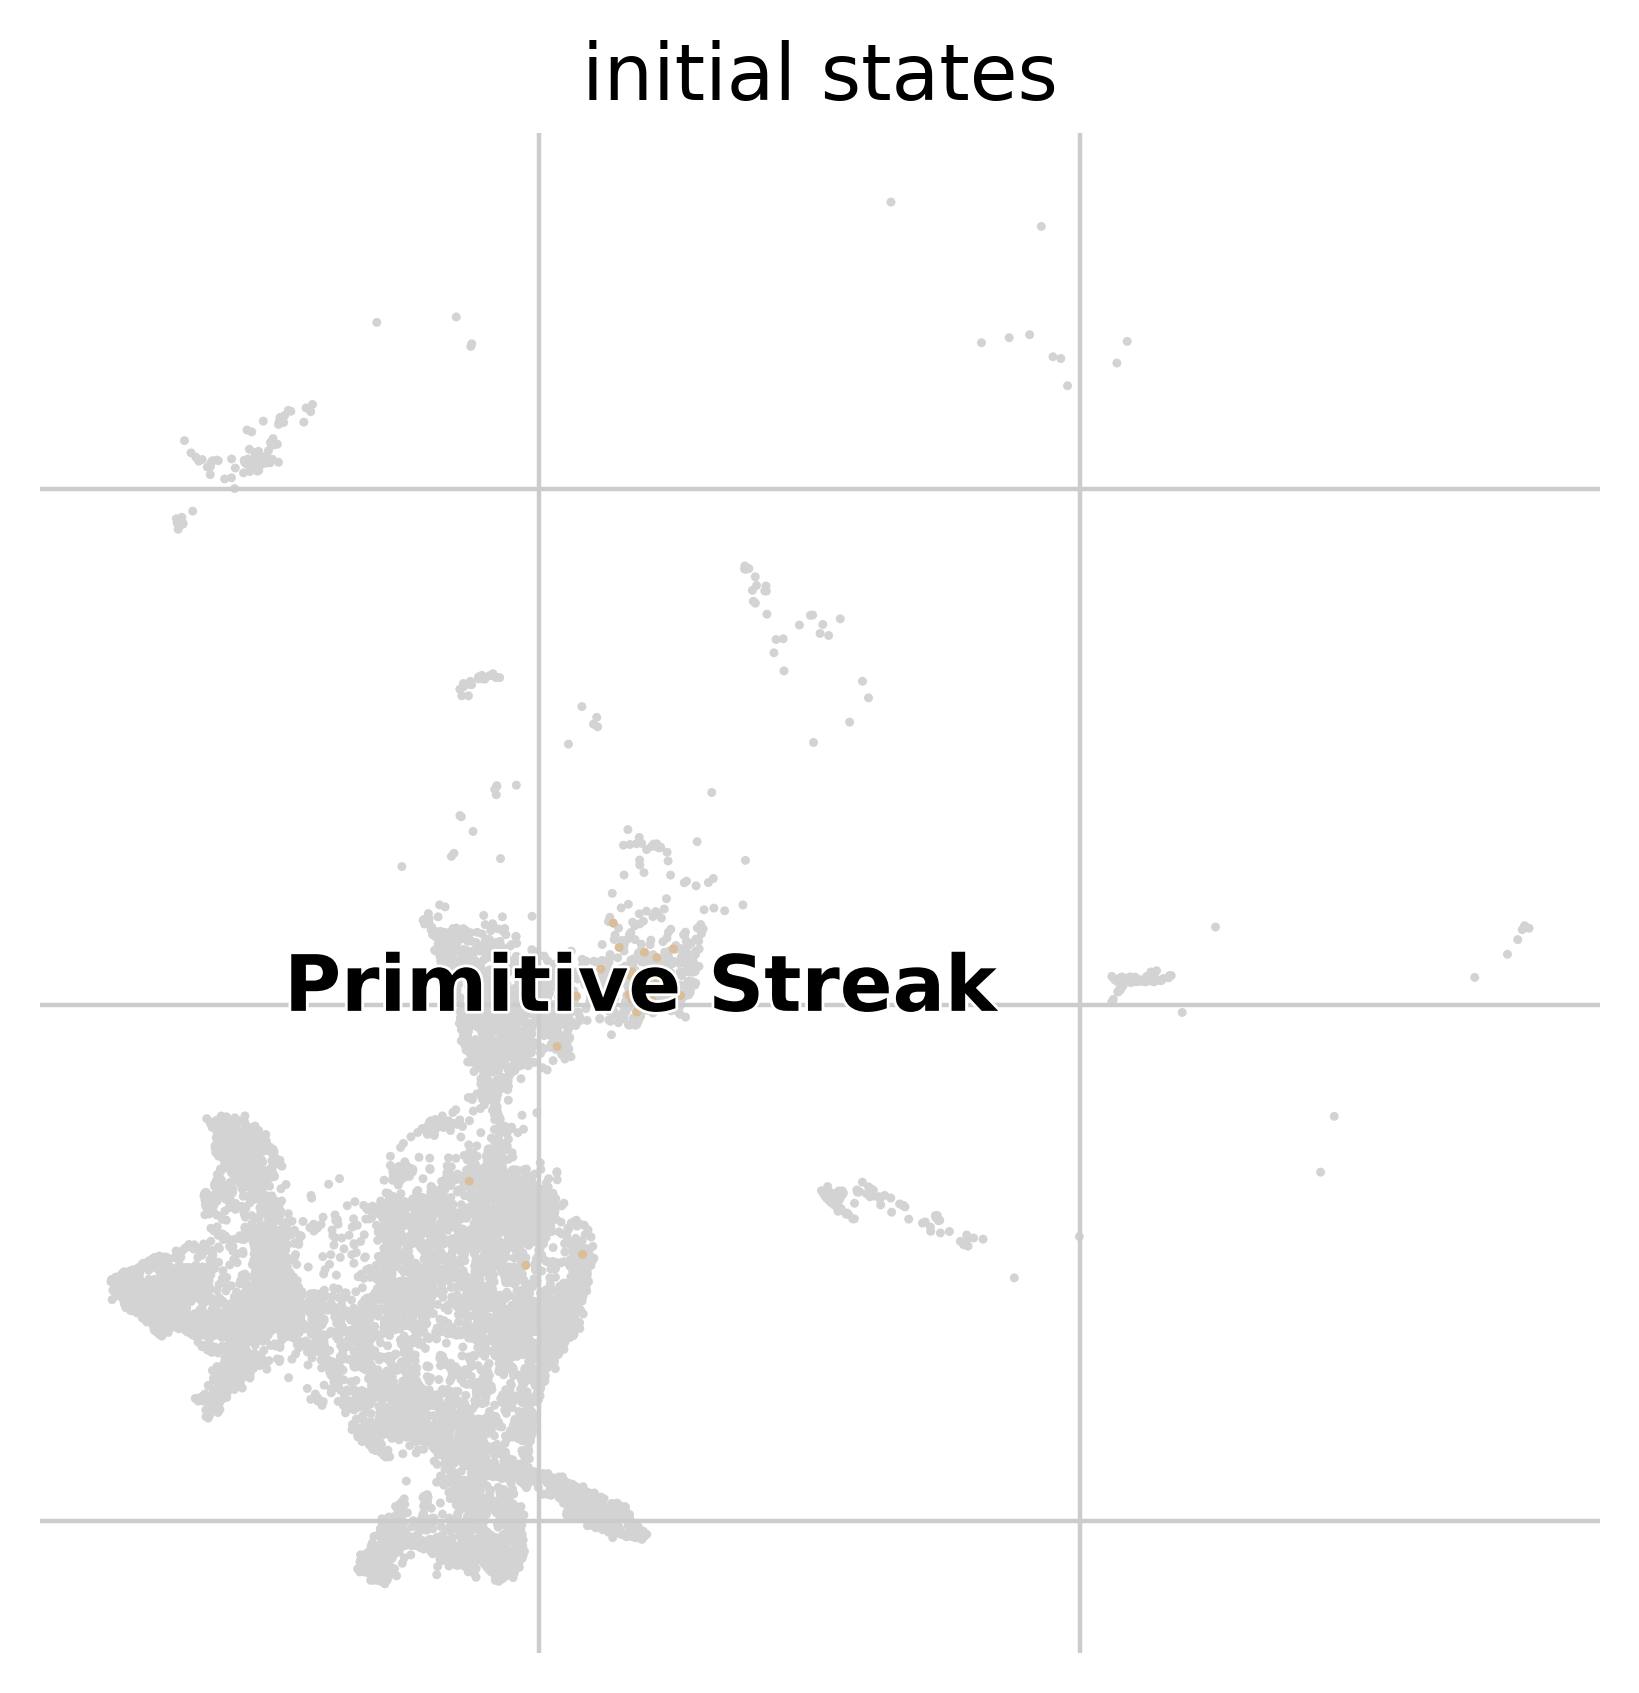

In [40]:
cr.tl.initial_states(adata, cluster_key=label)
cr.pl.initial_states(adata, discrete=True, dpi = 200)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


  0%|          | 0/3 [00:00<?, ?/s]

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


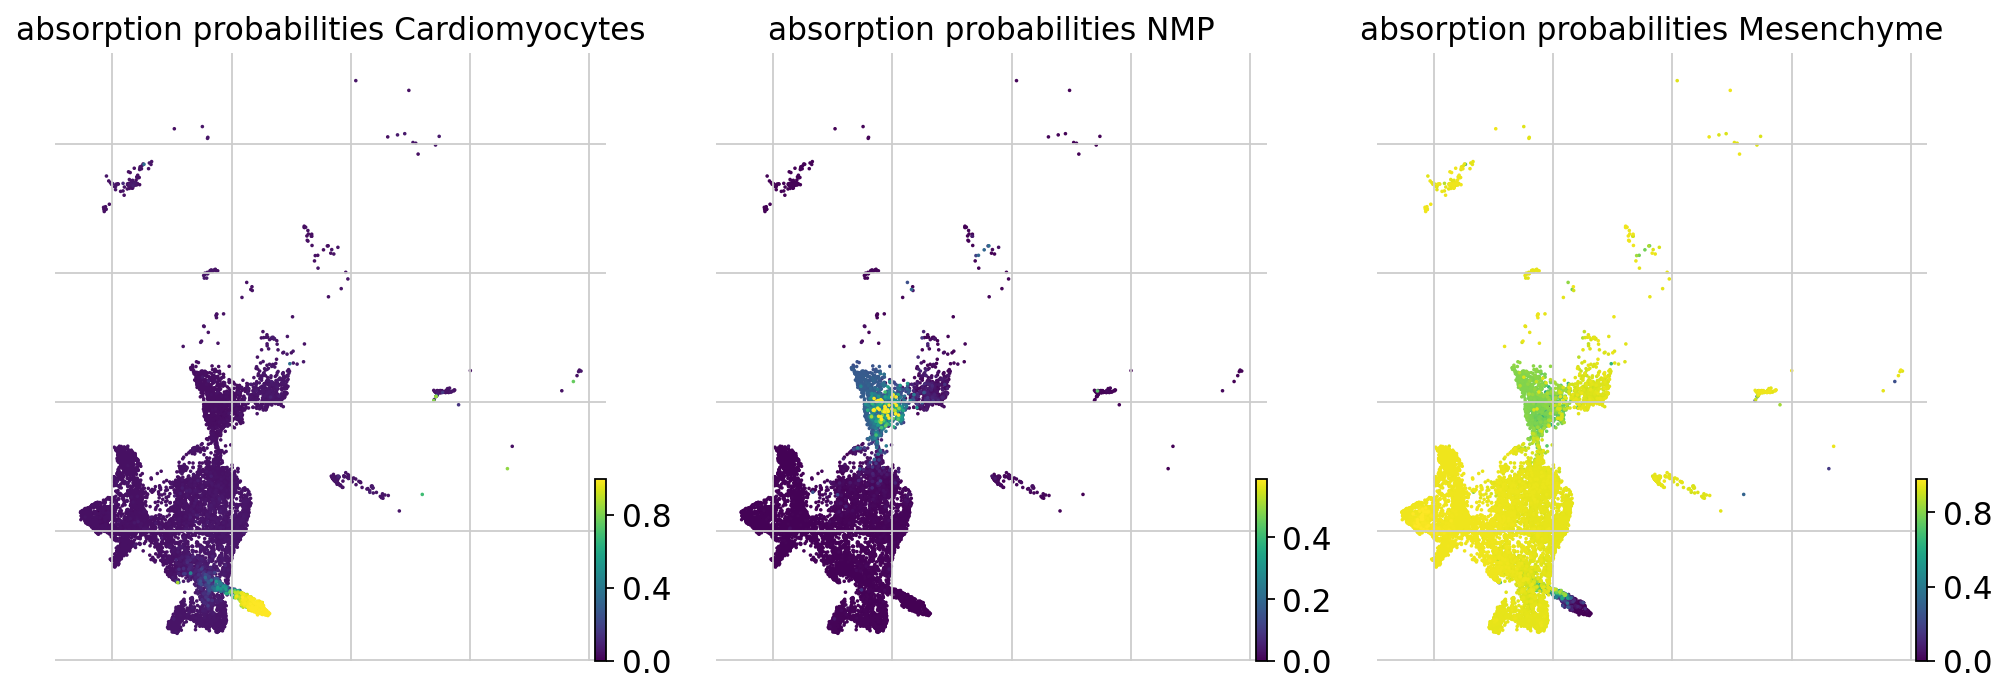

In [41]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False, )

In [46]:
i = 5

In [47]:
test = f"{i}hello"

In [48]:
test

'5hello'

In [53]:
rna.uns["hvg"]

{'flavor': 'seurat_v3'}

In [55]:
for i in [0, 2, 10]:
    print(i)
print("hello")

0
2
10
hello


In [60]:
adata

AnnData object with n_obs × n_vars = 11577 × 2000
    obs: 'sample', 'barcode', 'stage', 'nFeature_RNA', 'nCount_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'pass_rnaQC', 'celltype.mapped', 'celltype.score', 'closest.cell', 'hybrid_score', 'doublet_call', 'TSSEnrichment_atac', 'ReadsInTSS_atac', 'PromoterRatio_atac', 'NucleosomeRatio_atac', 'nFrags_atac', 'BlacklistRatio_atac', 'pass_atacQC', 'celltype.predicted', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', '_scvi_batch', '_scvi_labels', 'n_counts', 'latent_time_gm', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'terminal_states', 'terminal_states_probs', 'clusters_gradients', 'initial_states', 'initial_states_probs'
    var: 'gene', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_n

In [61]:
A = "X"

In [63]:
adata.obsm[f"{A}_pca"] 

array([[-51.315926  ,   3.5585046 ,  -8.6659155 , ...,  -1.1559613 ,
         -0.43045804,  -4.2818966 ],
       [-42.815067  ,  -6.861315  ,  -6.9665074 , ...,   3.0826566 ,
          1.1920924 ,   2.389964  ],
       [  4.2455215 , -28.75964   ,  -6.428619  , ...,  -5.5364895 ,
         -6.302932  ,  -2.8358817 ],
       ...,
       [ 71.05394   , -42.999786  ,  -2.8640199 , ...,  14.707123  ,
         -8.250002  ,  -8.244249  ],
       [ -9.149834  ,  -6.71157   ,  -1.5785108 , ...,   3.082594  ,
         -5.1557302 ,   0.66106457],
       [-17.352795  ,   0.4014058 ,  -8.224456  , ...,   5.315836  ,
          6.5234003 ,   7.4527287 ]], dtype=float32)

### Use single trajectory - forebrain/midbrain/hindbrain


In [92]:
rostral = rna[rna.obs["celltype.mapped"].isin(["Forebrain_Midbrain_Hindbrain", "Neural_crest", "Rostral_neurectoderm", "Epiblast"]),] 

In [93]:
rostral.X = rostral.layers["counts"].todense()

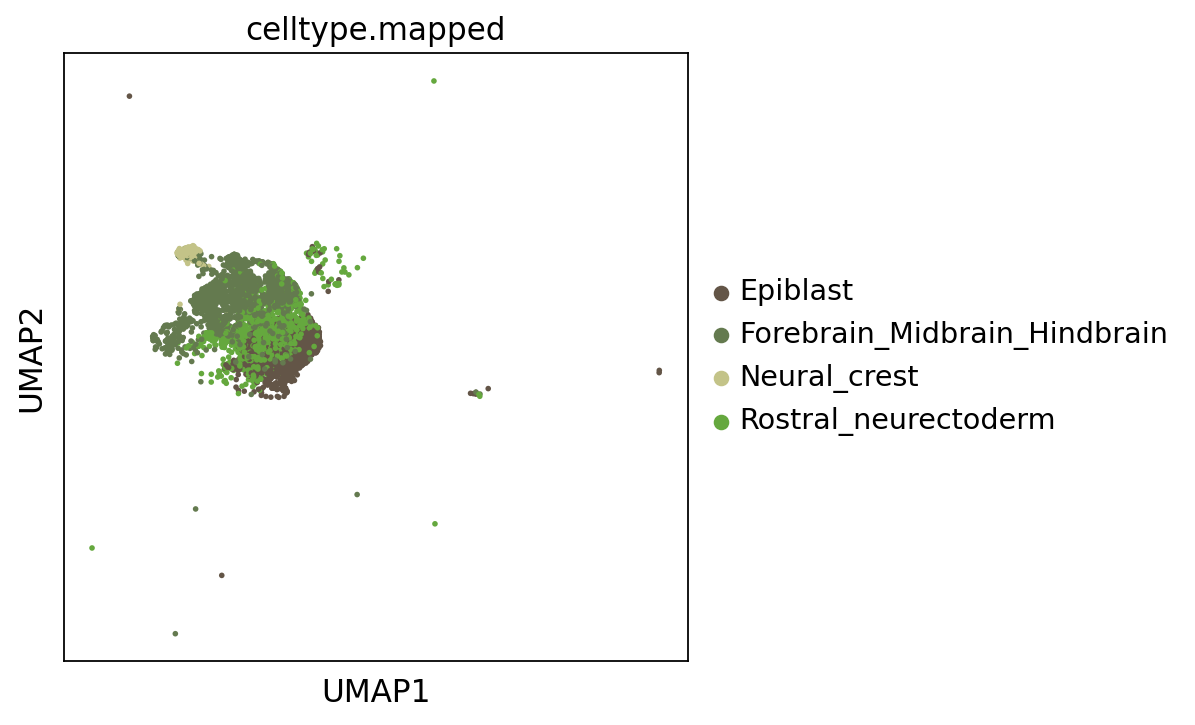

In [94]:
sc.pl.umap(rostral, color = "celltype.mapped")

In [96]:
#sc.write("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/UniTVelo/adata_brain_rostral_scvi.h5ad", rostral)

In [97]:
adata = sc.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/UniTVelo/unitvelo_adata_brain_rostral_scvi.h5ad")

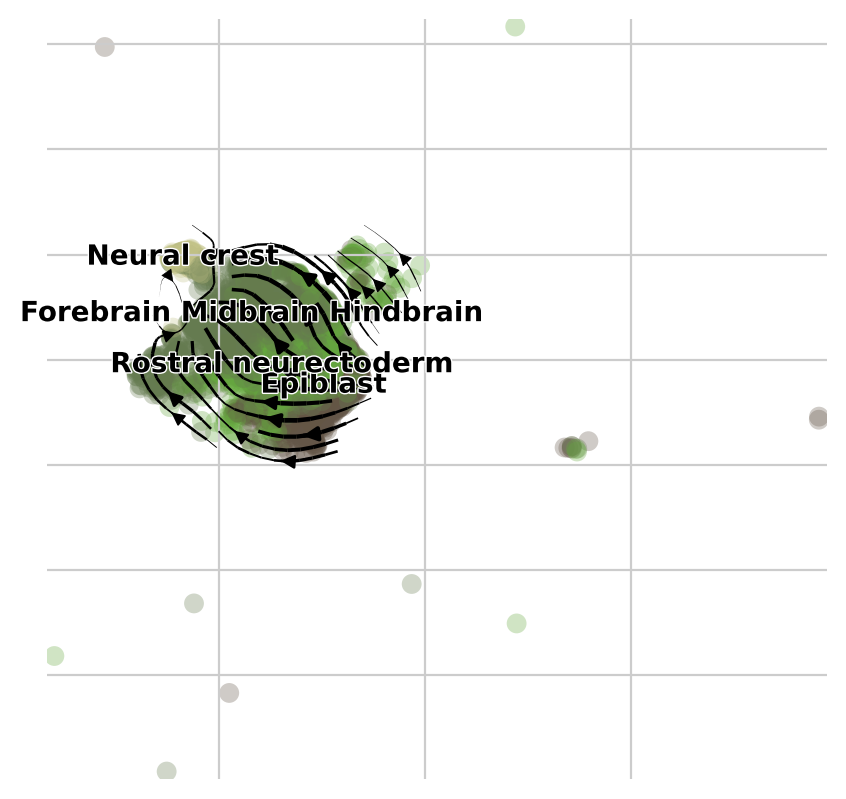

In [103]:
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='', legend_fontsize = 10)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.
/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/cellrank/tl/_init_term_states.py:161: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  **kwargs,


  0%|          | 0/4710 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/4710 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: [0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


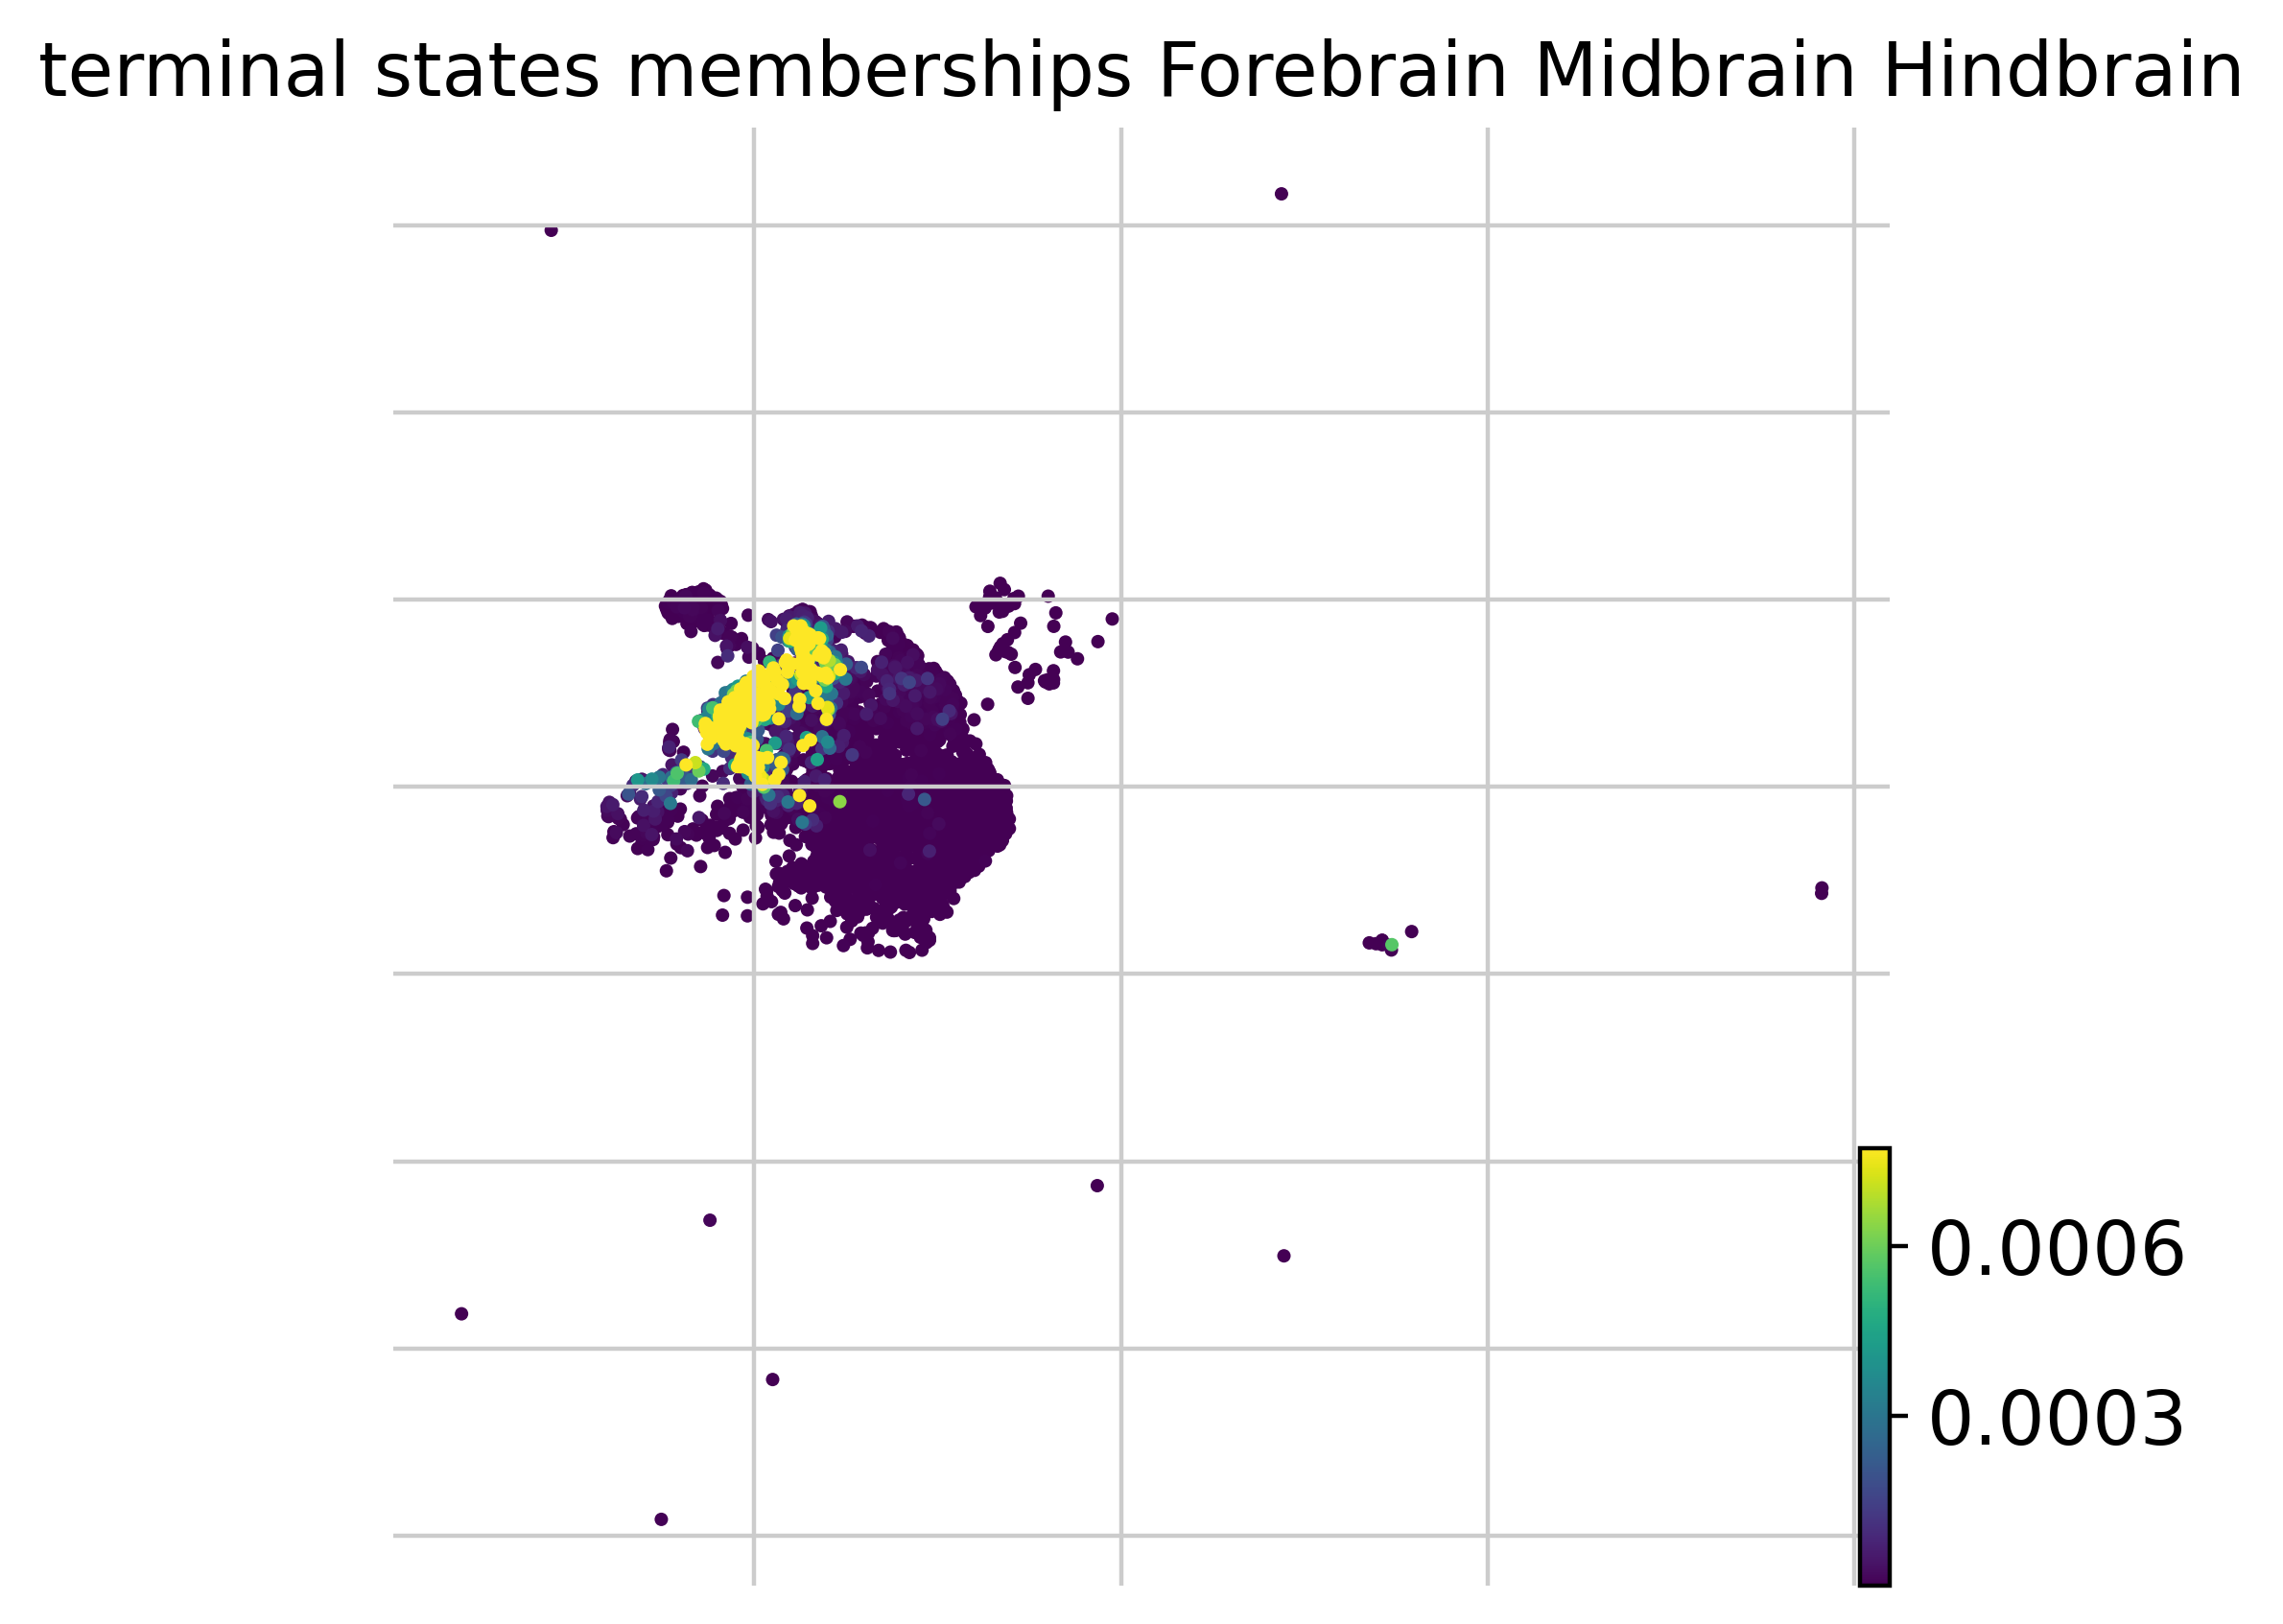

In [104]:
cr.tl.terminal_states(adata, cluster_key=label, weight_connectivities=0.2)#, n_states=4)
cr.pl.terminal_states(adata, dpi = 200)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


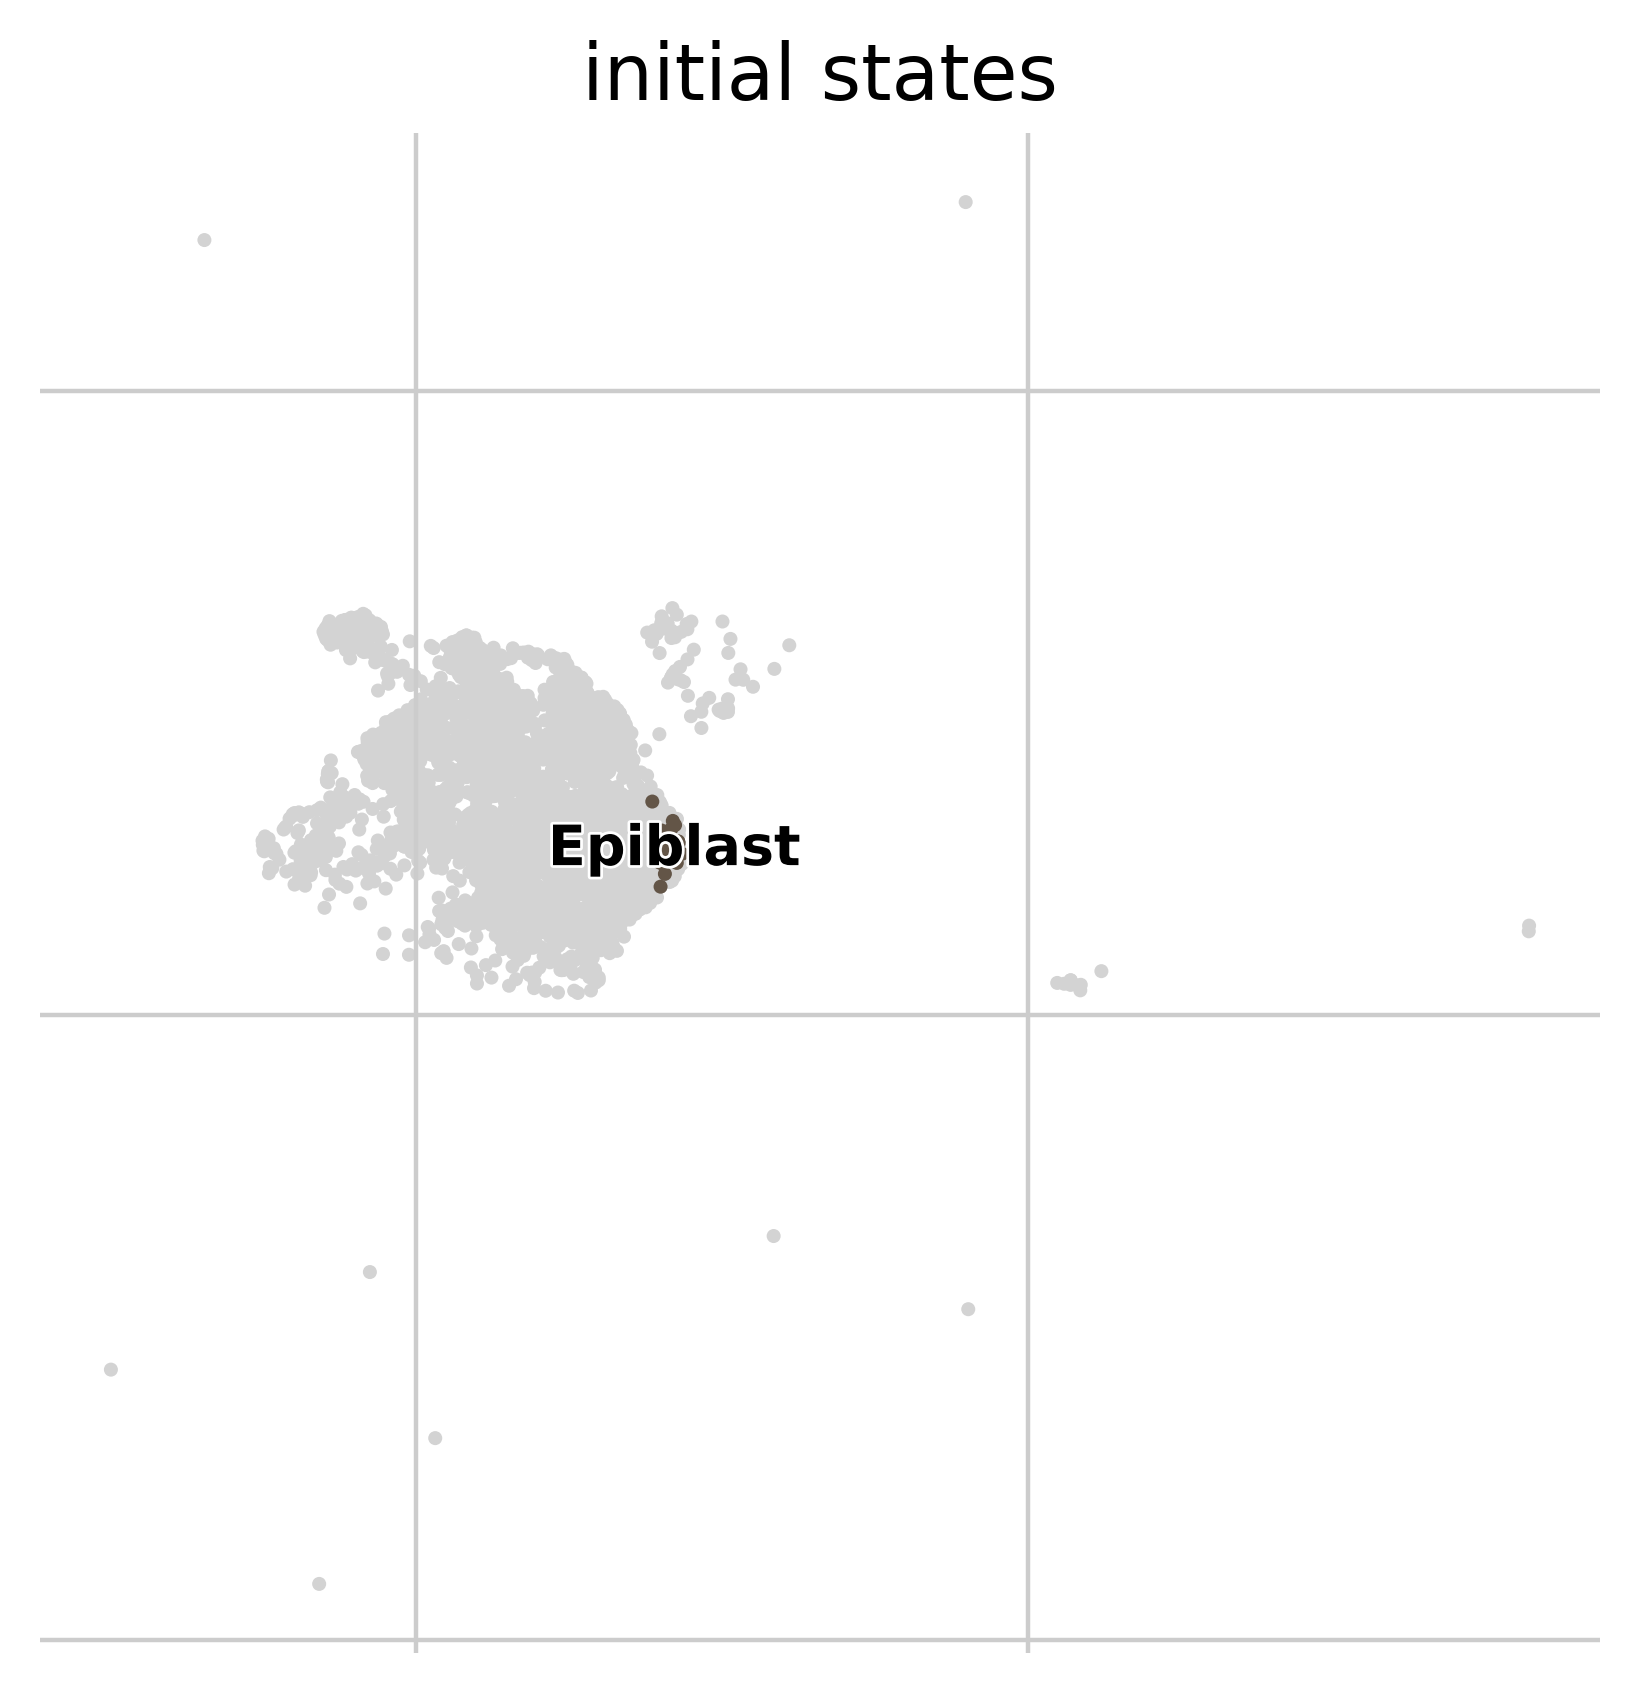

In [107]:
cr.tl.initial_states(adata, cluster_key=label)
cr.pl.initial_states(adata, discrete=True, dpi = 200, legend_fontsize = 10)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


  0%|          | 0/1 [00:00<?, ?/s]

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


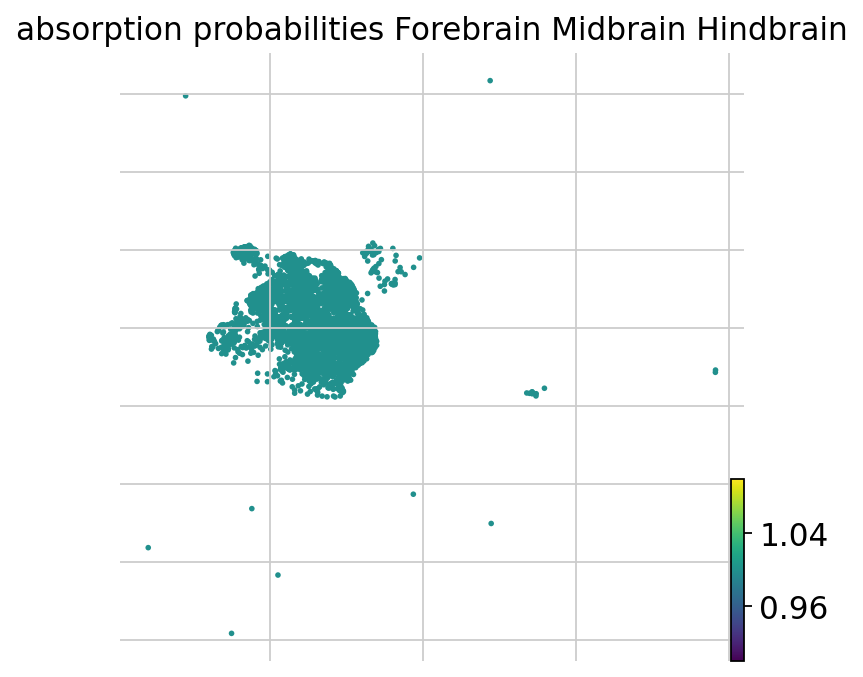

In [108]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False, )

### Use single trajectory - Spinal Cord

In [77]:
caudal = rna[rna.obs["celltype.mapped"].isin(["Spinal_cord", "Caudal_neurectoderm", "Epiblast", "Caudal_epiblast"]),] 

In [78]:
caudal.X = caudal.layers["counts"].todense()

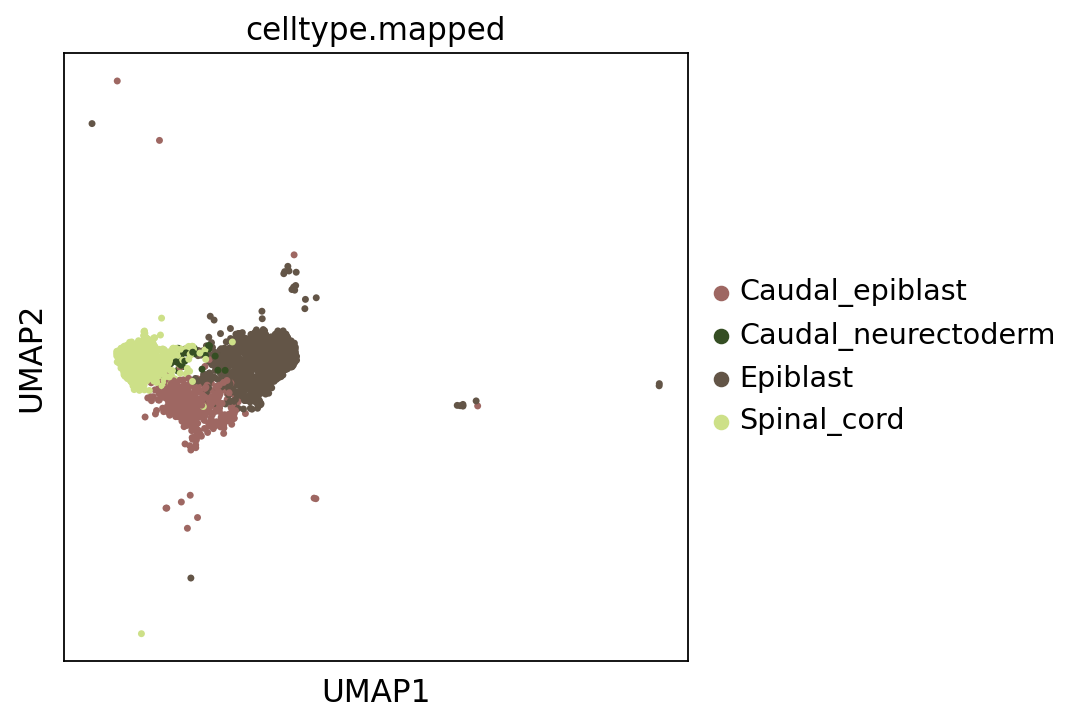

In [79]:
sc.pl.umap(rostral, color = "celltype.mapped")

In [82]:
#sc.write("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/UniTVelo/adata_brain_caudal_scvi.h5ad", caudal)

In [111]:
adata = sc.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/UniTVelo/unitvelo_adata_brain_caudal_scvi.h5ad")

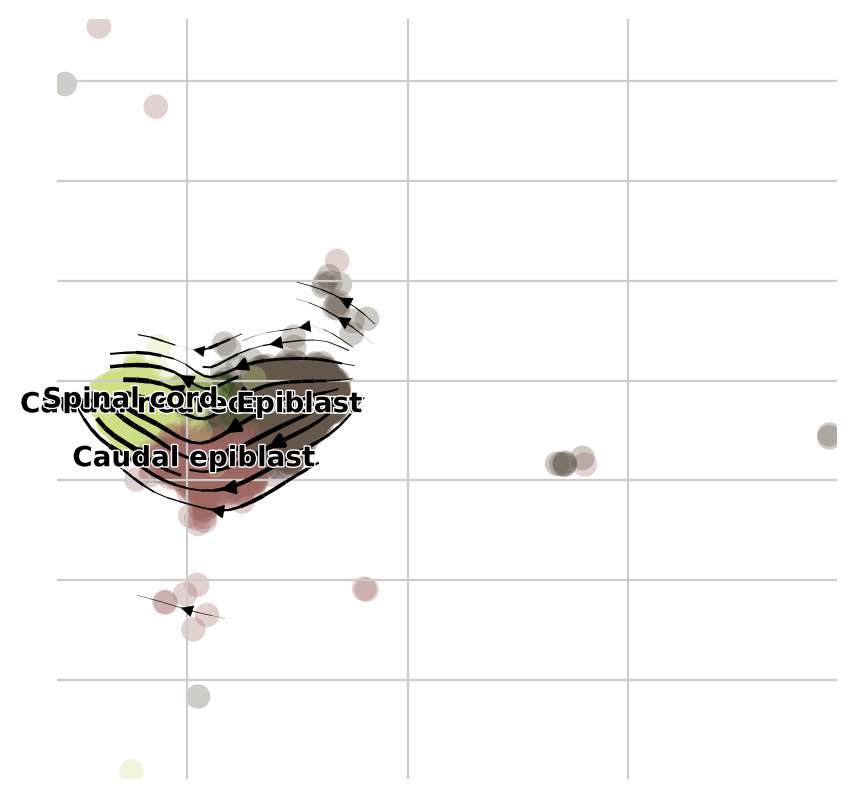

In [112]:
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='', legend_fontsize = 10)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.
/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


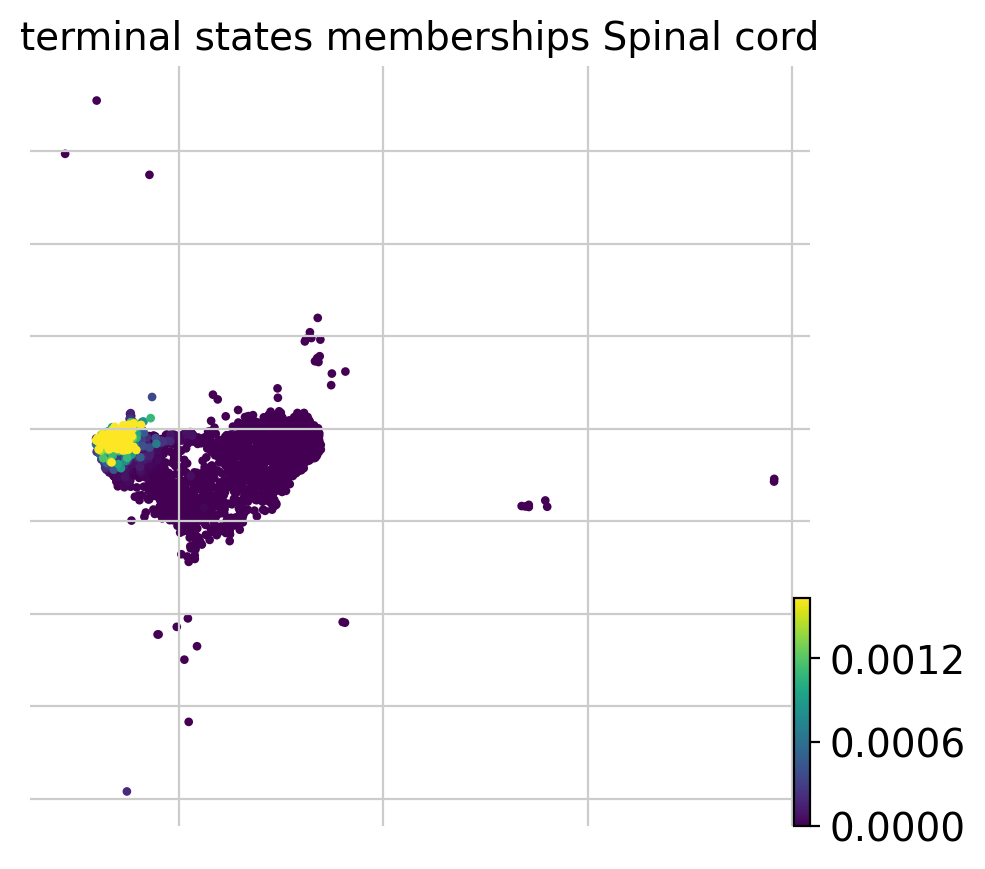

In [116]:
cr.tl.terminal_states(adata, cluster_key=label, weight_connectivities=0.2)#, n_states=4)
cr.pl.terminal_states(adata, dpi = 100, legend_fontsize = 10)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


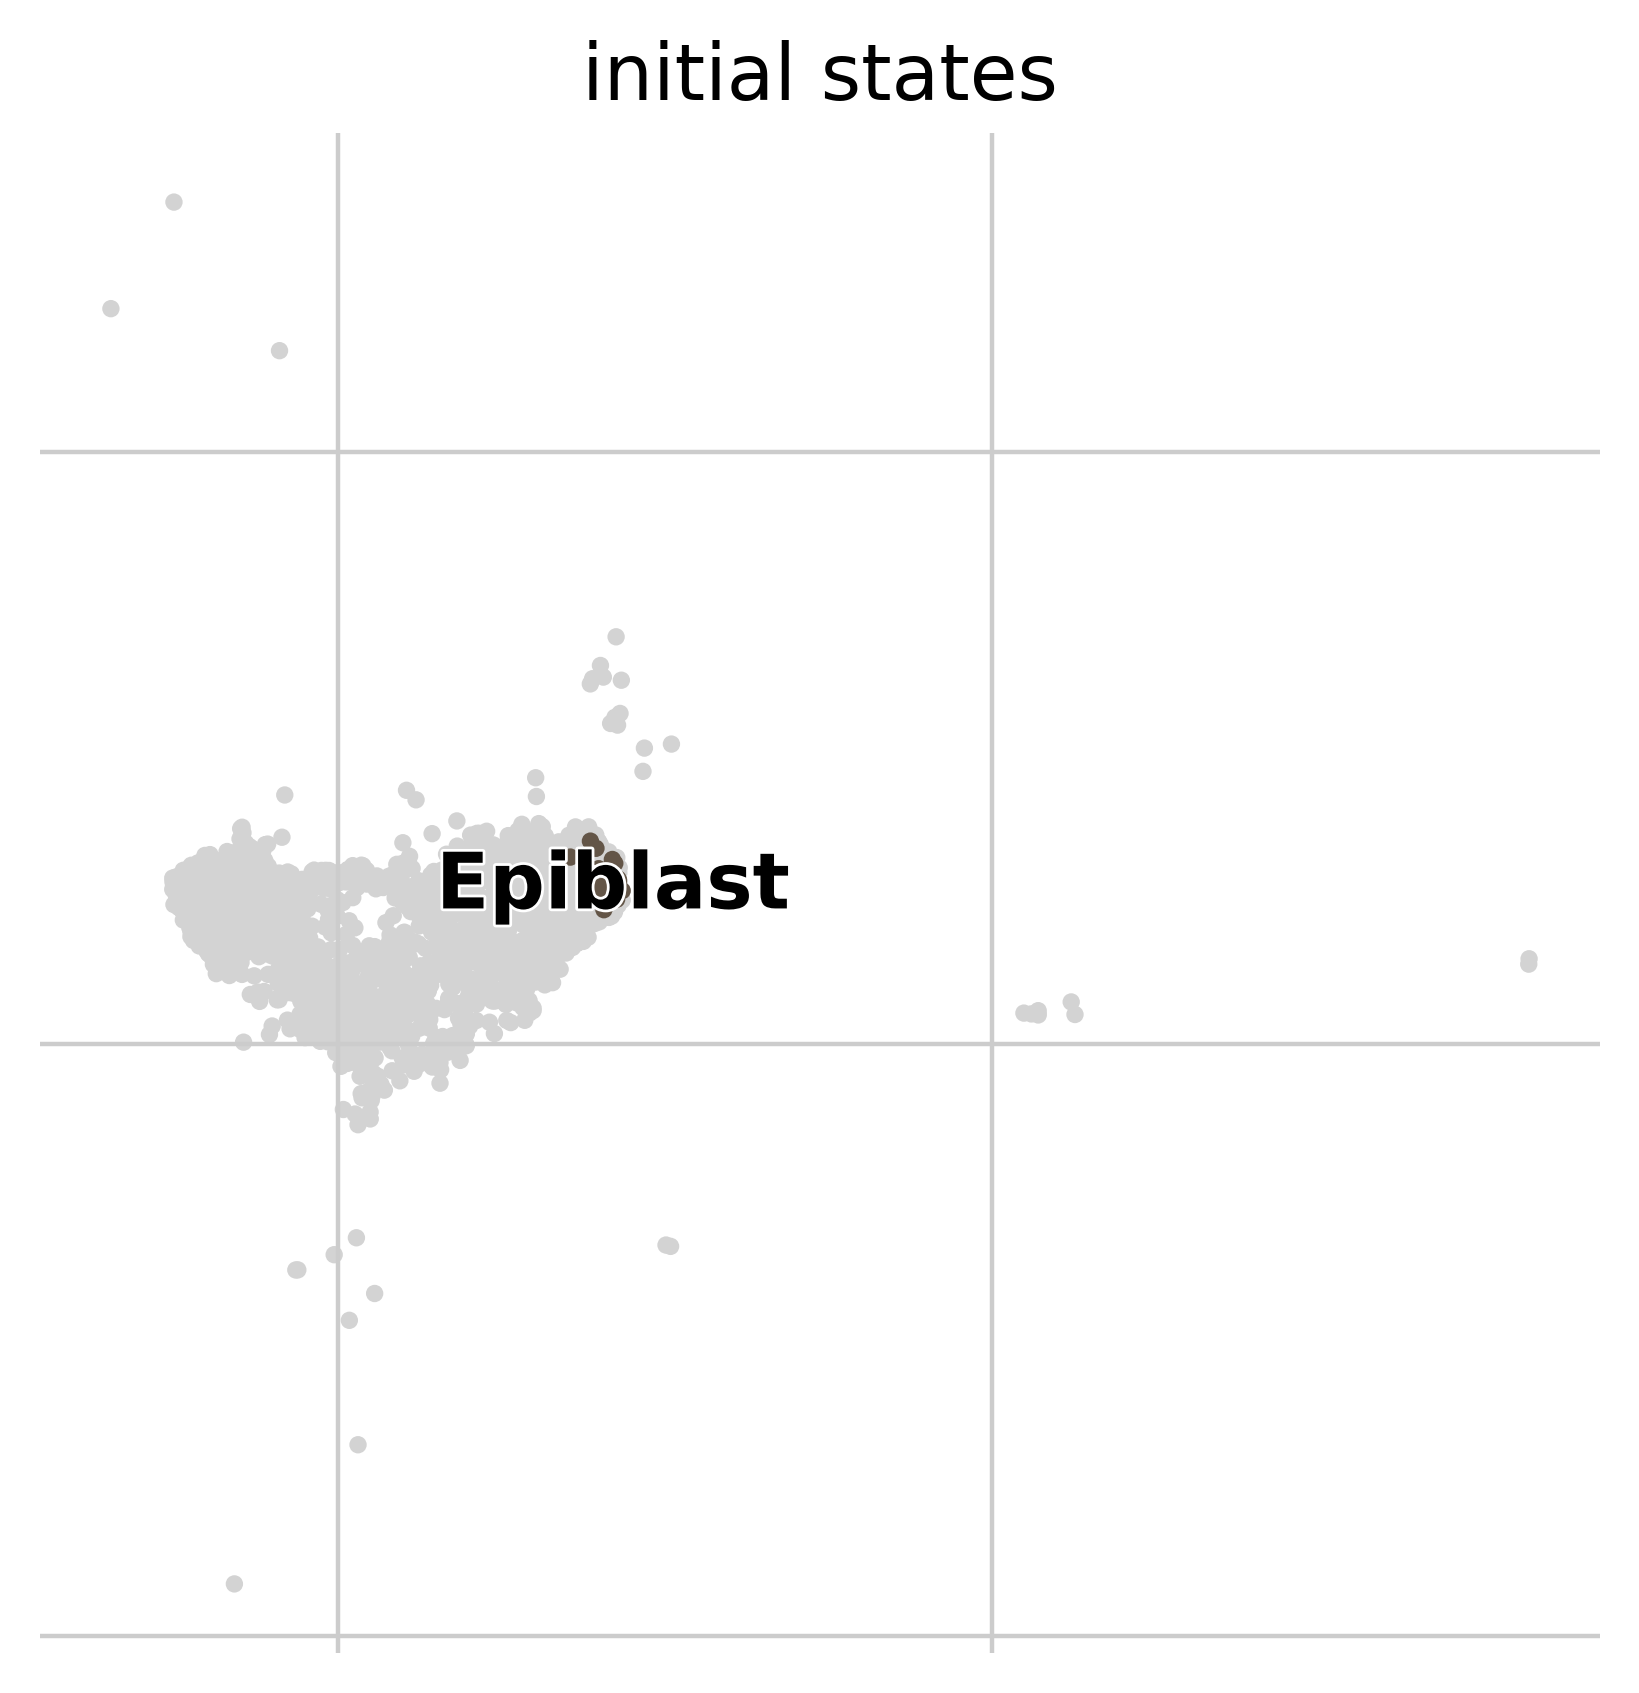

In [117]:
cr.tl.initial_states(adata, cluster_key=label)
cr.pl.initial_states(adata, discrete=True, dpi = 200)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


  0%|          | 0/1 [00:00<?, ?/s]

[0]PETSC ERROR: [0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: /omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


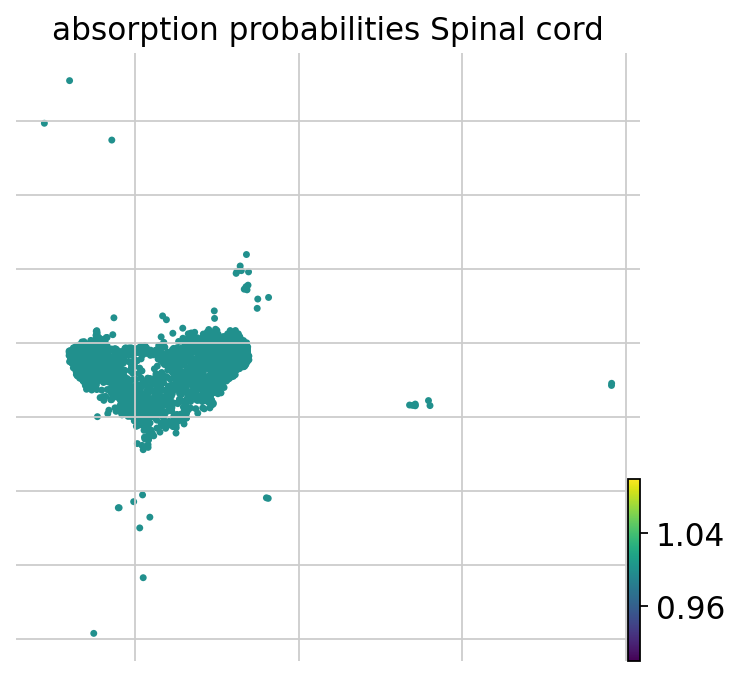

In [118]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False, )

### Brain trajectory


In [132]:
brain_sub = rna[rna.obs["celltype.mapped"].isin(["Forebrain_Midbrain_Hindbrain",  "Rostral_neurectoderm", "Spinal_cord", "Caudal_neurectoderm",  "Epiblast", "Caudal_epiblast"]),] 

In [133]:
brain_sub.X = brain_sub.layers["counts"].todense()

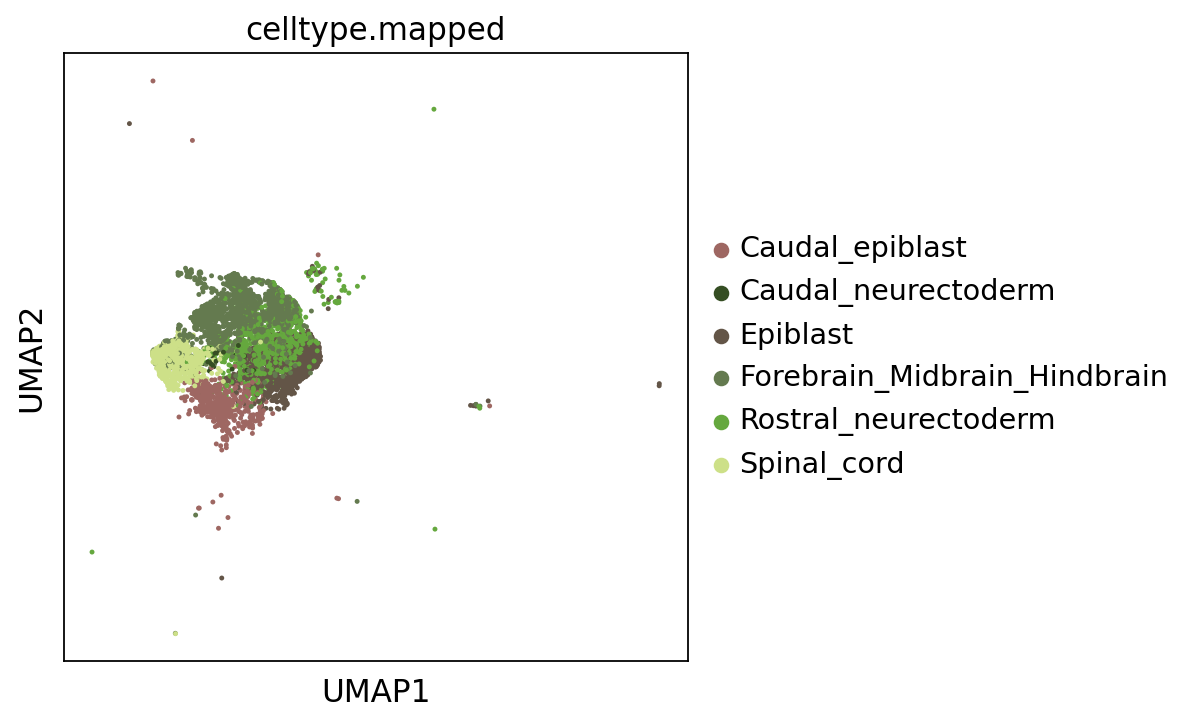

In [134]:
sc.pl.umap(brain_sub, color = "celltype.mapped")

In [136]:
#sc.write("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/UniTVelo/brain_sub_scvi.h5ad", brain_sub)

In [141]:
adata = sc.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/UniTVelo/unitvelo_brain_sub_scvi.h5ad")

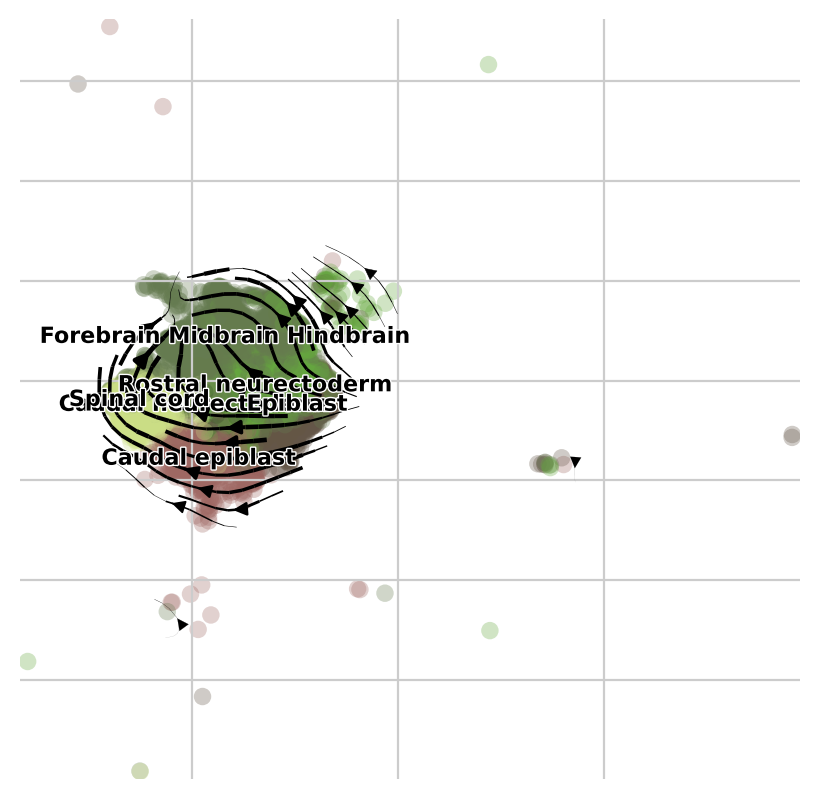

In [143]:
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='', legend_fontsize = 8)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000082e+00 -4.7228164462971706e-02 
0.0000000000000000e+00 9.5543759866183309e-01 


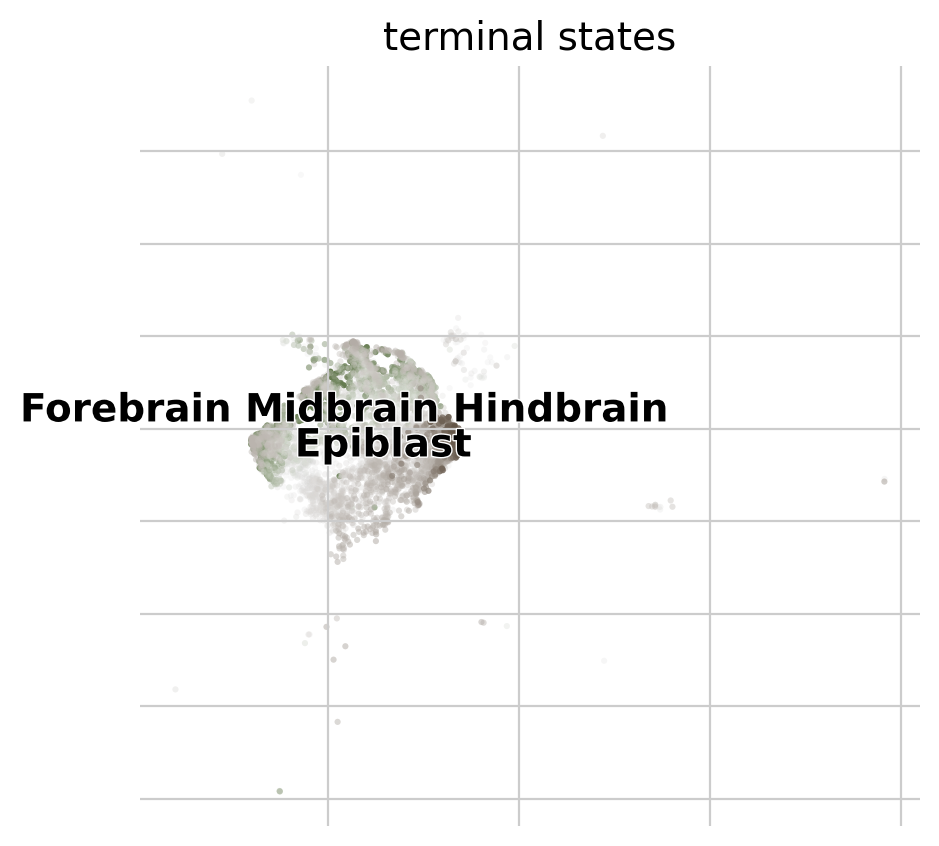

In [147]:
cr.tl.terminal_states(adata, cluster_key=label, weight_connectivities=0.2, n_states=2)
cr.pl.terminal_states(adata, dpi = 100)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


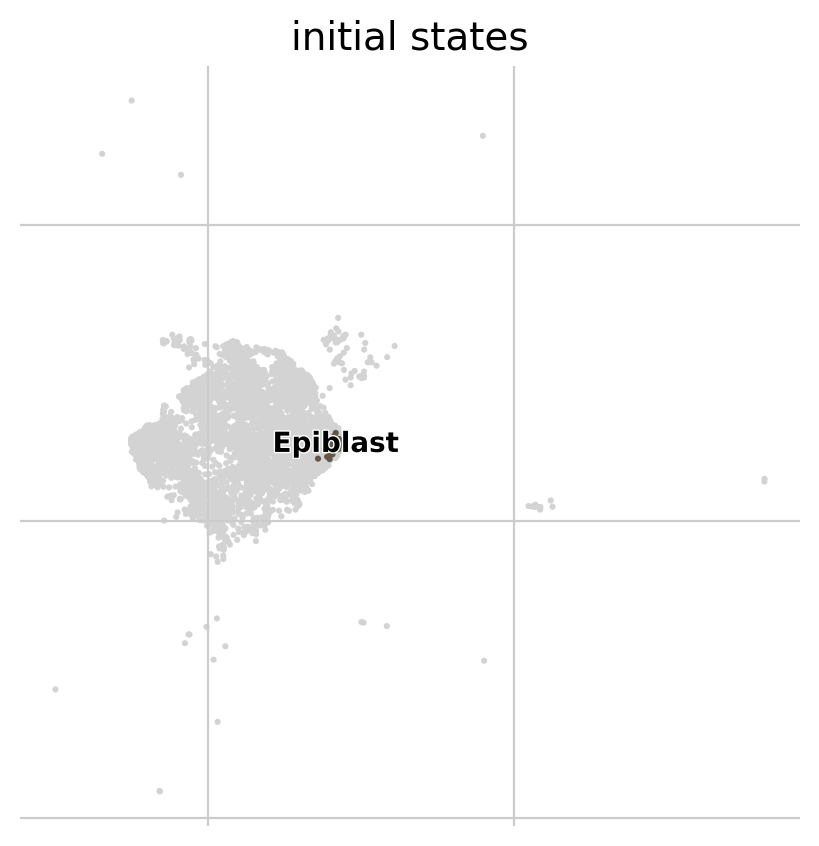

In [148]:
cr.tl.initial_states(adata, cluster_key=label)
cr.pl.initial_states(adata, discrete=True, dpi = 100, legend_fontsize = 10)

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


  0%|          | 0/2 [00:00<?, ?/s]

/omics/groups/OE0533/internal/katharina/unitvelo/lib/python3.7/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


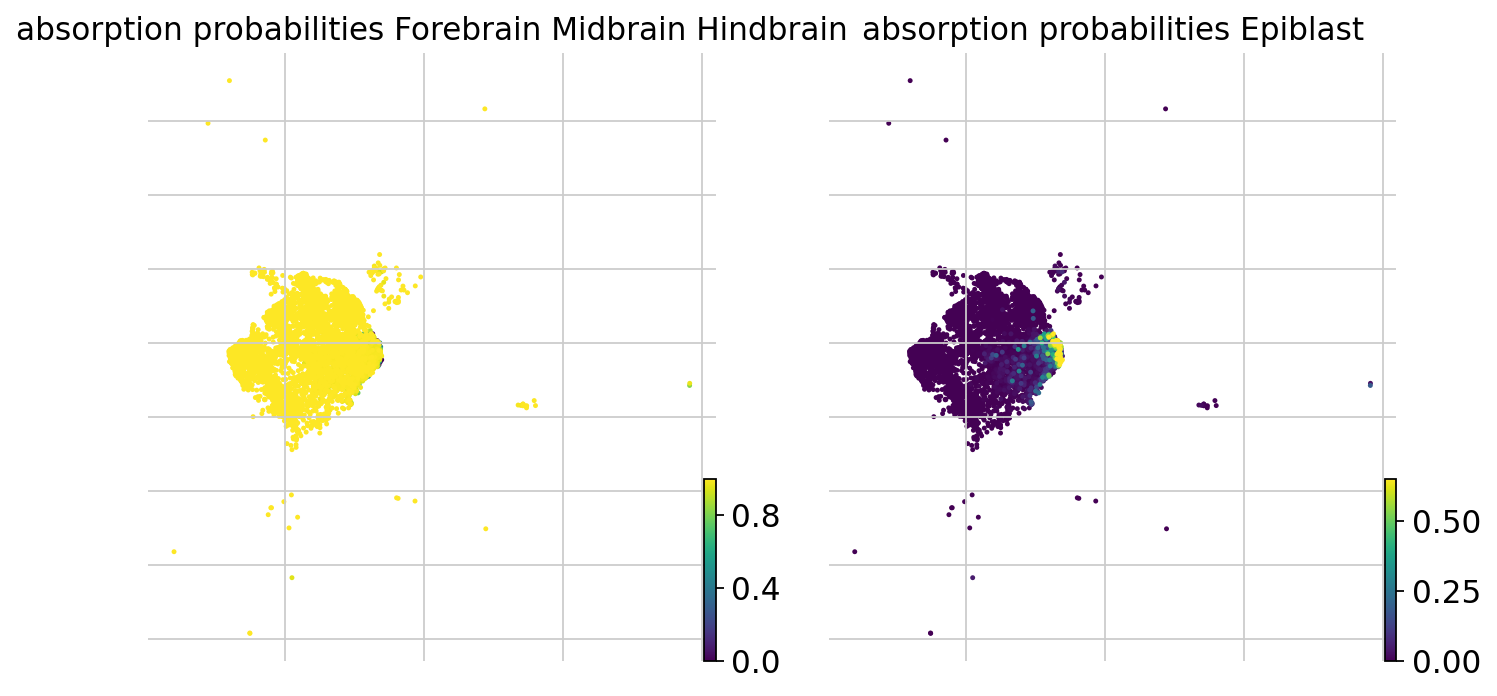

In [149]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False, )